# Analysing Software in Pubmed with SoftwareKG

The notebook intends to answer some of the most important questions about software in science based on the Pubmed Central Open Access article set. 
Data is collected and aggregated with SPARQL and processed and plotted with R. 
The script was tested with R 4.1.1.

First the required R packages are set up: 

In [1]:
library(tidyverse)
library(SPARQL)
library(digest)
library(tictoc)
library(xtable)
library(gridExtra)
library(grid)
library(ggplot2)
library(magrittr)

server = "http://your.endpoint.here:8890/sparql"

# ggplot theme
theme_sw <- function(){
     theme_bw() %+replace%    #replace elements we want to change
    
    theme(
        legend.position='top', 
              panel.border = element_blank(), 
              strip.background=element_rect(colour=NA, fill='#D1D1D1')
        )
}

color.scheme <- c("wo_software"="#1f78b4", 
                     "software_wo_add_info"="#a6cee3", 
                     "software_w_developer"="#b2df8a", 
                     "software_w_version"="#33a02c", 
                     "software_w_version_and_developer"="#fb9a99")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.5     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.0.2     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: XML

Loading required package: RCurl


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




We introduce a mechanism to cache the results of SPARQL queries in order to save run-time in case we need to re-execute queries. 
Be aware that any change in query strings will trigger a new query as the results are saved based on the queries hash value. 

We also set up a mechanism to directly output formatted latex tables.

In [2]:
run_and_cache <- function(query, cache.name="", print.query=FALSE){
    context = "
        PREFIX schema: <http://schema.org/>
        PREFIX nif: <http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#>
        PREFIX skg: <http://data.gesis.org/softwarekg/PMC/>
        PREFIX skgv: <http://data.gesis.org/softwarekg/vocab/>
        PREFIX dct: <http://purl.org/dc/terms/>
        PREFIX bibo: <http://purl.org/ontology/bibo/>
    "
    query = paste0(context, query)
    h = digest(query)
    fn = paste0(cache.name, '_', h, '.csv.bz2')
    if (! file.exists(fn)){
        cat(paste0("Cache not available, start query"))
        if (print.query){
            print(query)
        }
        tic("Query")
        res = SPARQL(url = server, query)$results
        write_csv(res, path = fn)
        toc()
    }
    return(read_csv(fn, show_col_types = FALSE))
}

latex_table <- function(tab.data, label, caption){
    print(
        xtable(tab.data),
        booktabs = FALSE, 
        hline.after=NULL,
        include.rownames = FALSE, 
        sanitize.text.function = base::identity,
        table.placement = "tb!",
        latex.environments=c("center")
      )
}

## SoftwareKG statistics overview

First we will take a look at all predicates existing in SoftwareKG to get a brief overview of the contained information.

Before we run any queries we define the default context for all SPARQL queries we want to run:

#### N-Triples

In [3]:
query = "
SELECT 
    COUNT(*) as ?Triples 
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE 
{ 
    ?s ?p ?o 
}"

res <- run_and_cache(query, cache.name = "triples")
print("Number of Triples")
head(res)

[1] "Number of Triples"


Triples
<dbl>
301825757


#### Predicate Overview

In [4]:
query = "
SELECT 
    DISTINCT ?Concept 
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE 
{ 
    ?a ?Concept ?b 
}"

res <- run_and_cache(query, cache.name = "concepts")
print("Predicates")
head(res)

[1] "Predicates"


Concept,Concept.1,Concept.2,Concept.3,Concept.4,Concept.5,Concept.6,Concept.7,Concept.8,Concept.9,⋯,Concept.37,Concept.38,Concept.39,Concept.40,Concept.41,Concept.42,Concept.43,Concept.44,Concept.45,Concept.46
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://schema.org/citation>,<http://data.gesis.org/softwarekg/vocab/citationCount>,<http://purl.org/dc/terms/date>,<http://purl.org/dc/terms/subject>,<http://data.gesis.org/softwarekg/vocab/H-Index>,<http://data.gesis.org/softwarekg/vocab/bestQuartile>,<http://data.gesis.org/softwarekg/vocab/hasJournalInformation>,<http://data.gesis.org/softwarekg/vocab/rank>,<http://schema.org/name>,⋯,<http://purl.org/ontology/bibo/eissn>,<http://purl.org/ontology/bibo/issn>,<http://schema.org/sameAs>,<http://www.w3.org/2004/02/skos/core#hasTopConcept>,<http://data.gesis.org/softwarekg/vocab/referredToByLicense>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#object>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#predicate>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#subject>,<http://data.gesis.org/softwarekg/vocab/confidence>,<http://data.gesis.org/softwarekg/vocab/hasVersion>


#### N-Unique Software and N-Mentions

We can now take a look at the number of unique software that is contained in softwareKG as well as the overall number of times the software was mentioned. 

In [5]:
query = "
SELECT 
    COUNT (DISTINCT ?software) as ?num_software
    COUNT (DISTINCT ?mention) as ?num_mention
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
     ?article <http://schema.org/mentions> ?mention .
     ?mention skgv:software ?software .
}"

res <- run_and_cache(query, cache.name="unique_software_count")
print("Number of software and mentions")
head(res)

[1] "Number of software and mentions"


num_software,num_mention
<dbl>,<dbl>
605352,11794679


#### N-Articles

In [6]:
res <- run_and_cache(query="
SELECT
    COUNT(DISTINCT ?article) as ?N_Articles
FROM
    <http://data.gesis.org/softwarekg2> 
WHERE{
    ?article a schema:ScholarlyArticle.
}
", cache.name='num_articles')
print("Number of articles")
head(res)

[1] "Number of articles"


N_Articles
<dbl>
3215346


#### N-Journals

In [7]:
res <- run_and_cache(query="
SELECT 
    COUNT (DISTINCT ?journal) as ?N_Journals
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE {
  ?journal a bibo:Journal .
}",cache.name="num_journals")
print("Number of Journals")
head(res)

[1] "Number of Journals"


N_Journals
<dbl>
15338


#### N-Publishers

In [8]:
res <- run_and_cache(query="
SELECT 
  count(DISTINCT ?publisher) as ?publisher_count
FROM 
  <http://data.gesis.org/softwarekg2> 
WHERE {
  ?journal a bibo:Journal ;
           dct:publisher ?publisher
}",cache.name="num_journals")
print("Number of journal publishers")
head(res)

[1] "Number of journal publishers"


publisher_count
<dbl>
2136


#### Journals with most articles
The following query will give us an overview of the journals with the most articles.

In [9]:
query = "
SELECT
    ?title
    COUNT(DISTINCT ?article) as ?num_article
FROM
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article dct:isPartOf/schema:name ?title
}"

num_articles_per_journal <- run_and_cache(query, cache.name="num_article_per_journal")
print("Number of articles per journal")
num_articles_per_journal %>%
    arrange(desc(num_article)) %>%
    head(.)

[1] "Number of articles per journal"


title,num_article
<chr>,<dbl>
PLoS ONE,239962
Bioinformation,152741
Scientific Reports,125673
Hospital (Lond 1886),76632
International Journal of Molecular Sciences,32439
Nature Communications,31069


#### Articles with citation count
The following query results in the number of articles with a citation count different from 0.
Citation count of 0 was artificially introduced for all articles that are not contained in the list of cited articles.

In [10]:
run_and_cache(query="
SELECT
    COUNT(?article) as ?num_articles_with_citation
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle;
                skgv:citationCount ?citation_count.
    FILTER(?citation_count != 0)
}")

num_articles_with_citation
<dbl>
2467895


## Setting up mappings

#### Software Names
Getting an overview of all software names that will be used later on.

In [11]:
query="      
SELECT 
    ?sw 
    ?name 
    ?max_ratio
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT 
            ?sw 
            MAX(?ratio) AS ?max_ratio
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?stmt a rdf:Statement ;
                  rdf:subject ?sw ;
                  rdf:predicate schema:name ;
                  skgv:confidence ?ratio .
        }
        GROUP BY ?sw
    }

    ?stmt a rdf:Statement ;
          rdf:subject ?sw ;
          rdf:predicate schema:name ;
          rdf:object ?name ;
          skgv:confidence ?max_ratio .
}
ORDER BY ?sw"

software_names = run_and_cache(query, cache.name="software_names")

head(software_names)
    

sw,name,max_ratio
<chr>,<chr>,<dbl>
<http://data.gesis.org/softwarekg/PMC/software/100000>,Arabidopsis Information Resource Center,1
<http://data.gesis.org/softwarekg/PMC/software/1000009>,MotAvg,1
<http://data.gesis.org/softwarekg/PMC/software/100001>,plexDB . org,1
<http://data.gesis.org/softwarekg/PMC/software/1000012>,Optima Edition,1
<http://data.gesis.org/softwarekg/PMC/software/1000013>,PSIPlan TPS,1
<http://data.gesis.org/softwarekg/PMC/software/1000014>,cmprskg,1


### Software Types

Getting an overview of the different software types

In [12]:
query="      
SELECT 
    ?sw 
    ?name 
    ?max_ratio
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT 
            ?sw 
            MAX(?ratio) AS ?max_ratio
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?stmt a rdf:Statement ;
                  rdf:subject ?sw ;
                  rdf:predicate skgv:softwareType ;
                  skgv:confidence ?ratio .
        }
        GROUP BY ?sw
    }

    ?stmt a rdf:Statement ;
          rdf:subject ?sw ;
          rdf:predicate skgv:softwareType ;
          rdf:object ?name ;
          skgv:confidence ?max_ratio .
}
ORDER BY ?sw"

software_types = run_and_cache(query, cache.name="software_types")

head(software_types)

sw,name,max_ratio
<chr>,<chr>,<dbl>
<http://data.gesis.org/softwarekg/PMC/software/100000>,<http://data.gesis.org/softwarekg/vocab/Application>,1
<http://data.gesis.org/softwarekg/PMC/software/1000009>,<http://data.gesis.org/softwarekg/vocab/Application>,1
<http://data.gesis.org/softwarekg/PMC/software/100001>,<http://data.gesis.org/softwarekg/vocab/PlugIn>,1
<http://data.gesis.org/softwarekg/PMC/software/1000012>,<http://data.gesis.org/softwarekg/vocab/Application>,1
<http://data.gesis.org/softwarekg/PMC/software/1000013>,<http://data.gesis.org/softwarekg/vocab/Application>,1
<http://data.gesis.org/softwarekg/PMC/software/1000014>,<http://data.gesis.org/softwarekg/vocab/PlugIn>,1


In [13]:
nn = nrow(software_types)

software_types %>%
group_by(name) %>%
summarise(n=n()/nn)


name,n
<chr>,<dbl>
<http://data.gesis.org/softwarekg/vocab/Application>,0.885216648
<http://data.gesis.org/softwarekg/vocab/OperatingSystem>,0.003326456
<http://data.gesis.org/softwarekg/vocab/PlugIn>,0.107378400
<http://data.gesis.org/softwarekg/vocab/ProgrammingEnvironment>,0.004078496


In [14]:
software_names %>%
inner_join(software_types, by="sw") %>%
filter(name.x=="R")

sw,name.x,max_ratio.x,name.y,max_ratio.y
<chr>,<chr>,<dbl>,<chr>,<dbl>
<http://data.gesis.org/softwarekg/PMC/software/1474942>,R,1,<http://data.gesis.org/softwarekg/vocab/ProgrammingEnvironment>,0.998691


#### Journal Ranks
Getting journal Scimago journal ranks as well as top level journals Domains and transforming them into percentiles.  

In [15]:
journal_ranks = run_and_cache(query="
SELECT
    ?journal 
    year(?date) as ?year
    ?rank
    ?domain_name
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?journal skgv:hasJournalInformation ?jinfo ;
             dct:subject/skos:hasTopConcept/schema:name ?domain_name .
    ?jinfo dct:date ?date;
           skgv:rank ?rank.
}
", cache.name="journal_ranks")


journal_ranks %>%
    distinct() %>%
    group_by(domain_name, year) %>%
    mutate(rank_100=ntile(rank, 100), rank_20=ntile(rank,20),rank_25=ntile(rank,25)) %>%
    ungroup() %>%
    arrange(desc(year), rank) ->
    journal_rank_percentile

head(journal_rank_percentile)

journal,year,rank,domain_name,rank_100,rank_20,rank_25
<chr>,<dbl>,<dbl>,<chr>,<int>,<int>,<int>
<http://data.gesis.org/softwarekg/PMC/journal/588>,2019,0.1,Medicine,1,1,1
<http://data.gesis.org/softwarekg/PMC/journal/8015>,2019,0.1,Medicine,1,1,1
<http://data.gesis.org/softwarekg/PMC/journal/4228>,2019,0.1,Chemistry,1,1,1
<http://data.gesis.org/softwarekg/PMC/journal/4228>,2019,0.1,Chemical Engineering,1,1,1
<http://data.gesis.org/softwarekg/PMC/journal/4228>,2019,0.1,"Biochemistry, Genetics and Molecular Biology",1,1,1
<http://data.gesis.org/softwarekg/PMC/journal/1783>,2019,0.1,Medicine,1,1,1


#### Software Names
Number of different names for each software

In [16]:
names_per_software = run_and_cache(query="
SELECT 
    ?software
    COUNT(DISTINCT ?stmt) as ?num_names
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?stmt a rdf:Statement;
          rdf:subject ?software;
          rdf:predicate schema:name;
          rdf:object ?name.
}
", cache.name="names_per_software")

## Research Domains and Subdomains

The research domains considered by SoftwareKG are defined by Scimago. 
There are top level domains as well as sub-categories assigned to them. 
The query below gives an overview of both.

#### Domain and Sub-domain list

In [17]:
query="
SELECT
    ?domain
    GROUP_CONCAT(DISTINCT ?category; SEPARATOR=\", \") AS ?categories
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?journal dct:subject ?d.
    ?d schema:name ?category;
       skos:hasTopConcept/schema:name ?domain .
}
GROUP BY ?domain"

research_domains <- run_and_cache(query, cache.name="research_domains")
print("Overview of research domains and corresponding categories")
head(research_domains)
#latex_table(research_domains, label = 'tab:domains')

[1] "Overview of research domains and corresponding categories"


domain,categories
<chr>,<chr>
Earth and Planetary Sciences,"Atmospheric Science, Computers in Earth Sciences, Earth and Planetary Sciences (miscellaneous), Earth-Surface Processes, Economic Geology, Geochemistry and Petrology, Geology, Geophysics, Geotechnical Engineering and Engineering Geology, Oceanography, Paleontology, Space and Planetary Science, Stratigraphy"
Veterinary,"Equine, Food Animals, Small Animals, Veterinary (miscellaneous)"
Social Sciences,"Anthropology, Archeology, Communication, Cultural Studies, Demography, Development, E-learning, Education, Gender Studies, Geography, Planning and Development, Health (social science), Human Factors and Ergonomics, Law, Library and Information Sciences, Life-span and Life-course Studies, Linguistics and Language, Political Science and International Relations, Public Administration, Safety Research, Social Sciences (miscellaneous), Social Work, Sociology and Political Science, Transportation, Urban Studies"
Chemical Engineering,"Bioengineering, Catalysis, Chemical Engineering (miscellaneous), Chemical Health and Safety, Colloid and Surface Chemistry, Filtration and Separation, Fluid Flow and Transfer Processes, Process Chemistry and Technology"
Multidisciplinary,Multidisciplinary
Nursing,"Advanced and Specialized Nursing, Assessment and Diagnosis, Care Planning, Community and Home Care, Critical Care Nursing, Emergency Nursing, Fundamentals and Skills, Gerontology, Issues, Ethics and Legal Aspects, LPN and LVN, Leadership and Management, Maternity and Midwifery, Medical and Surgical Nursing, Nurse Assisting, Nursing (miscellaneous), Nutrition and Dietetics, Oncology (nursing), Pediatrics, Pharmacology (nursing), Psychiatric Mental Health, Research and Theory, Review and Exam Preparation"


#### N-Articles, N-Mentions per Domain
Now we can analyze the number of journals and respective articles that belong the defined categories. 
We only look at the top level domains due to the large number of categories. 

In [18]:
query="
SELECT
    ?domain
    COUNT(DISTINCT ?article) as ?num_articles
    COUNT(DISTINCT ?journal) as ?num_journals
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?journal dct:subject/skos:hasTopConcept/schema:name ?domain .
    ?article dct:isPartOf ?journal
}
GROUP BY ?domain
ORDER BY DESC(?num_articles)"

papers_per_domain <- run_and_cache(query, cache.name="papers_per_domain")

papers_per_domain %>%
    mutate(domain=stringr::str_split(domain, ",") %>% map_chr(., 1)) %>%
    mutate(domain=stringr::str_split(domain, " ") %>% map_chr(., 1)) -> 
    res
print("Number of articles and journals for each research domain")
sum(res$num_articles)
head(res)
#latex_table(res, label = 'tab:papers_per_domains')

[1] "Number of articles and journals for each research domain"


[1] 5203873

domain,num_articles,num_journals
<chr>,<dbl>,<dbl>
Medicine,1938910,4455
Biochemistry,1039046,1560
Agricultural,416495,743
Immunology,266712,451
Chemistry,213184,407
Neuroscience,175350,451


Saving names in a list

In [19]:
domains = c("Agricultural and Biological Sciences",
            "Arts and Humanities",
            "Economics, Econometrics and Finance",
            "Energy",
            "Engineering",
            "Environmental Science",
            "Health Professions",
            "Immunology and Microbiology",
            "Materials Science",
            "Mathematics",
            "Medicine",
            "Multidisciplinary",
            "Biochemistry, Genetics and Molecular Biology",
            "Neuroscience",
            "Nursing",
            "Pharmacology, Toxicology and Pharmaceutics",
            "Physics and Astronomy",
            "Psychology",
            "Social Sciences",
            "Veterinary",
            "Business, Management and Accounting",
            "Chemical Engineering",
            "Chemistry",
            "Computer Science",
            "Decision Sciences",
            "Dentistry",
            "Earth and Planetary Sciences")

## Software in Science

#### (Cumulative) Distribution of software 

software,num_mention,num_mention_per_software,percent_mention
<chr>,<dbl>,<dbl>,<dbl>
<http://data.gesis.org/softwarekg/PMC/software/104768>,11794679,1,8.4784e-06
<http://data.gesis.org/softwarekg/PMC/software/1053744>,11794679,1,8.4784e-06
<http://data.gesis.org/softwarekg/PMC/software/1133595>,11794679,1,8.4784e-06
<http://data.gesis.org/softwarekg/PMC/software/1151203>,11794679,1,8.4784e-06
<http://data.gesis.org/softwarekg/PMC/software/1178508>,11794679,1,8.4784e-06
<http://data.gesis.org/softwarekg/PMC/software/1188972>,11794679,1,8.4784e-06


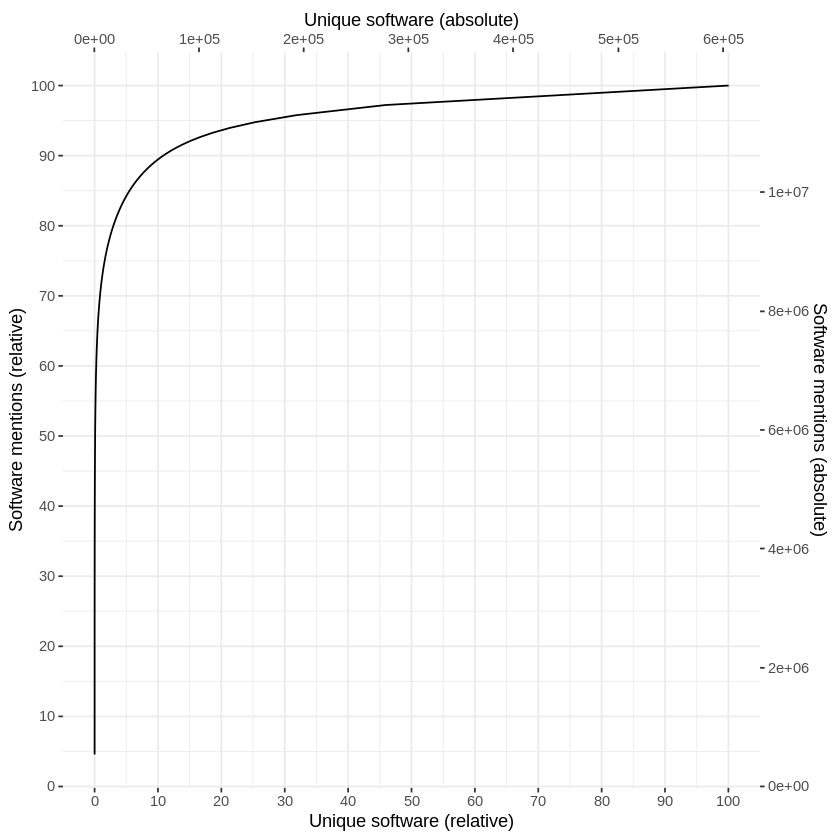

In [20]:
query = "

SELECT 
    ?software
    ?num_mention 
    ?num_mention_per_software 
    xsd:float(?num_mention_per_software)/xsd:float(?num_mention) * 100 as ?percent_mention
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
     SELECT 
        ?software 
        (COUNT(DISTINCT ?mention) as ?num_mention_per_software) 
        (COUNT(DISTINCT ?string) as ?num_string_per_software)
    FROM 
        <http://data.gesis.org/softwarekg2> 
     WHERE
      {
         ?mention skgv:software ?software .
      }
     group by ?software
     }
     {
     SELECT 
        (COUNT(DISTINCT ?mention) as ?num_mention) 
        (COUNT(DISTINCT ?string) as ?num_string)
    FROM 
        <http://data.gesis.org/softwarekg2> 
     WHERE
      {
       ?mention skgv:software ?software .
      }
  }
 }
"

res_mention = run_and_cache(query, cache.name = 'mention_per_software')
head(res_mention)

res_mention %>% 
    dplyr::arrange(desc(num_mention_per_software)) %>%
    dplyr::mutate(pmentions =  cumsum(percent_mention), psoftware=(1:n())*100/n(), nsoftware=1:n()) %>%
    ggplot(., aes(x=psoftware)) + 
        geom_line(aes(y = pmentions)) +         
        scale_x_continuous("Unique software (relative)", 
                           breaks=seq(0,100,by=10),
                           sec.axis = sec_axis(~ . *605363/100, breaks=seq(0,605363, by=100000), 
                                               name = "Unique software (absolute)")) +
        scale_y_continuous("Software mentions (relative)", 
                           breaks=seq(0,100,by=10),
                           sec.axis = sec_axis(~ . *11795002/100, breaks=seq(0,11795002, by=2000000), 
                                               name = "Software mentions (absolute)")) +
        theme_sw() ->
    p

ggsave(filename = "cdf_mentions.png", plot=p, width=10, height=3)
p


#### (Overall) Most common software

Overall most common software across all disciplines

In [21]:
query = "
SELECT 
    count(DISTINCT ?mention) as ?num_abs_mention
    xsd:float(count(DISTINCT ?mention))*100/xsd:float(?num_all_mentions) as ?num_rel_mention
    count(DISTINCT ?article) as ?num_article
    ?software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
     ?article schema:mentions ?mention .
     ?mention skgv:software ?software .
    { 
        SELECT 
            COUNT(DISTINCT ?m) as ?num_all_mentions
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE { 
            ?m skgv:software ?s
        }
    }
}
group by ?software ?num_all_mentions
ORDER BY DESC(?num_article)
limit 10
"
res_software_frequencies = run_and_cache(query, cache.name = 'software_frequencies')
res_software_frequencies %>%
    inner_join(software_names, by =c('software'='sw')) %>%
    inner_join(names_per_software, by='software') -> 
    df_most_common_software
df_most_common_software

num_abs_mention,num_rel_mention,num_article,software,name,max_ratio,num_names
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
539250,4.57198,466505,<http://data.gesis.org/softwarekg/PMC/software/1482531>,SPSS,0.784069,440
469751,3.98274,235180,<http://data.gesis.org/softwarekg/PMC/software/1474942>,R,1.000000,1
220175,1.86673,189578,<http://data.gesis.org/softwarekg/PMC/software/1474895>,Prism,1.000000,1
228140,1.93426,144737,<http://data.gesis.org/softwarekg/PMC/software/1513869>,ImageJ,0.748576,83
140941,1.19495,127691,<http://data.gesis.org/softwarekg/PMC/software/1474915>,Windows,0.936657,6
147586,1.25129,118413,<http://data.gesis.org/softwarekg/PMC/software/1588559>,Stata,0.523867,141
151613,1.28544,118082,<http://data.gesis.org/softwarekg/PMC/software/1474910>,Excel,0.864497,54
140214,1.18879,112679,<http://data.gesis.org/softwarekg/PMC/software/1493396>,SAS,0.914695,215
271343,2.30055,104734,<http://data.gesis.org/softwarekg/PMC/software/1477448>,BLAST,0.562352,383


#### Domain specific most common software
Most common software for each research domain

Warning message:
“Removed 1053 rows containing missing values (geom_text).”
Warning message:
“Removed 1053 rows containing missing values (geom_text).”


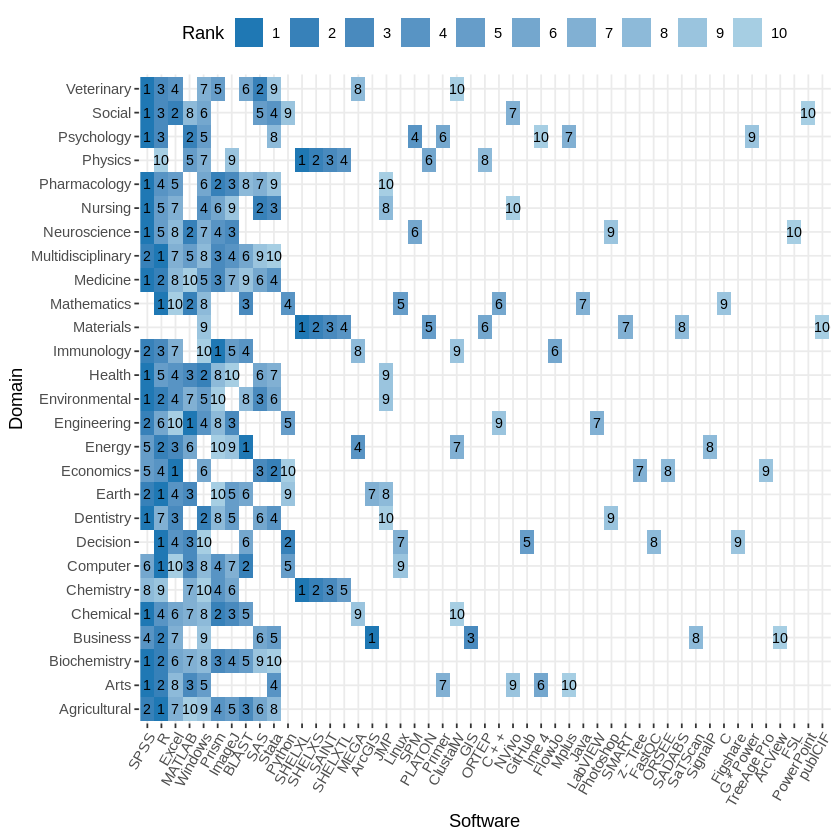

In [22]:
#per domain

query_template = "
SELECT 
    COUNT(DISTINCT ?mention) as ?num_abs_mention
    xsd:float(count(DISTINCT ?mention))*100/xsd:float(?num_all_mentions) as ?num_rel_mention
    ?num_all_mentions
    COUNT(DISTINCT ?article) as ?num_article
    xsd:float(count(DISTINCT ?article))*100/xsd:float(?num_all_articles) as ?num_rel_article
    ?num_all_articles
    ?software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
     ?article schema:mentions ?mention;
              dct:isPartOf/dct:subject/skos:hasTopConcept ?domain.

     ?domain schema:name \"%s\" .
     ?mention skgv:software ?software .
    { 
        SELECT 
            ?domain 
            COUNT(DISTINCT ?m) as ?num_all_mentions
            COUNT(DISTINCT ?a) as ?num_all_articles
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE 
        { 
            ?a schema:mentions ?m;
               dct:isPartOf/dct:subject/skos:hasTopConcept ?domain.
            ?m skgv:software ?s.
        }
    }
}
GROUP BY ?software ?num_all_mentions ?num_all_articles
ORDER BY DESC(?num_article)
limit 10
"
cache_template = "top_software_in_%s"

top_software_in_domains = bind_rows(lapply(domains, function(domain){
    query = sprintf(query_template,domain)
    cache = sprintf(cache_template,domain)
    df = run_and_cache(query=query, cache.name=cache, print.query=TRUE)
    df$domain = domain
    df
    }))

top_software_in_domains %>%
    inner_join(software_names, by =c('software'='sw')) %>%
    group_by(domain) %>%
    mutate(i=row_number()) %>%
    ungroup() %>%
    select(domain, name, i) %>%
    tidyr::complete(domain,nesting(name)) %>%
    mutate(i2 = ifelse(is.na(i),11,i)) %>%
    mutate(a = ifelse(is.na(i),0,1)) %>%
    mutate(domain=stringr::str_split(domain, ",") %>% map_chr(., 1)) %>%
    mutate(domain=stringr::str_split(domain, " ") %>% map_chr(., 1)) %>%
    ungroup() %>%
    group_by(name) %>%
    mutate(ii=sum(i2)) ->
top_software_gg

    ggplot(top_software_gg,aes(domain,reorder(name,ii))) + 
        geom_raster(data=subset(top_software_gg, !is.na(i)), aes(fill=factor(i))) + 
        theme_sw() +
        theme(axis.text.x = element_text(angle=60, hjust = 1), legend.position='top') + 
        geom_text(aes(label=i),size=3) + 
        ylab("Software") + xlab("Domain") +
        #scale_fill_gradient(low = '#33a02c', high = '#a6cee3', na.value = 'transparent') 
        scale_fill_manual("Rank", 
                          values=scales::seq_gradient_pal("#1f78b4", "#a6cee3", "Lab")(seq(0,1,length.out=10)), 
                          labels=c(1:10,'>10')) +
        guides(fill=guide_legend(nrow=1,byrow=TRUE))  + 
coord_flip()->
p

ggsave(filename = "top_software_per_domain.png", plot=p, width=10, height=6)
p

        

### Software Names and Spelling

Overall spellings

In [23]:
paste0('Spellings per software: max: ', 
       max(names_per_software$num_names), 
       ', min: ', 
       min(names_per_software$num_names),
       ', avg: ', 
       mean(names_per_software$num_names))

[1] "Spellings per software: max: 440, min: 1, avg: 1.08404696771465"

Spellings for SPSS:

In [24]:
spss_spellings = run_and_cache(query="
SELECT
    ?name 
    ?confidence
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE {
   ?statement a rdf:Statement;
              rdf:subject <http://data.gesis.org/softwarekg/PMC/software/1482531>;
              rdf:predicate schema:name;
              rdf:object ?name ;
              skgv:confidence ?confidence .  
}
ORDER BY DESC(?confidence)
")
spss_spellings %>%
    dplyr::arrange(desc(confidence)) %>%
    head(.)
spss_spellings %>%
    dplyr::arrange(desc(confidence)) %>%
    tail(.)

name,confidence
<chr>,<dbl>
SPSS,0.78406900
SPSS Statistics,0.10766500
Statistical Package for the Social Sciences,0.03806380
Statistical Package for Social Sciences,0.02846180
SPSS statistics,0.01326580
Statistical Package for Social Science,0.00662169


name,confidence
<chr>,<dbl>
Statistical Package from the Social Sciences,7.14533e-07
statistical package social science,7.14533e-07
Statistical Package For the Social Science,7.14533e-07
statistical package for the social solution,7.14533e-07
Statistical Package for the Spcial Sciences,5.35900e-07
Stasistical package for Social Sciences,4.28720e-07


## Usage and Citation Completeness Trends

We now have an overview of the dataset and move on to analyzing software in science. 
The questions we address have are interesting to the scientific community and have been investigated with smaller datasets. 

1. Software over time

    1.1 How do software mentions in science progress over time?
    
    1.2 How software mention completeness progress over time? 
    
To answer this questions we need data on the number of articles mentioning software, the number of articles not mentioning software, and the number of articles including additional information with software that is required to consider a mention as complete with respect to reproducibility. 

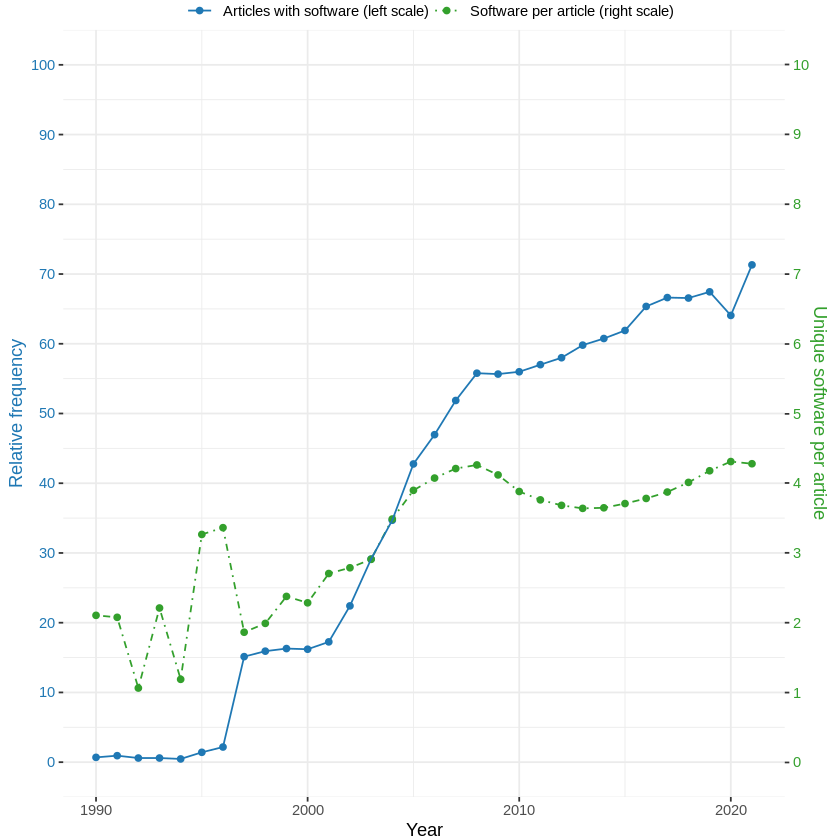

In [25]:
# software per article

avg_software_per_year = run_and_cache("
SELECT
    AVG(xsd:float(?num_software)) as ?avg_software
    ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT
        COUNT(DISTINCT ?software) as ?num_software
        ?article
        year(?date) as ?year
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{

        ?article schema:mentions ?mention;
                schema:datePublished ?date.
        ?mention skgv:software ?software.

    FILTER (year(?date) >= 1990)
}
    group by ?article ?date
}
group by ?year
")
#avg_software_per_year

# articles per year not mentioning software
query="
SELECT 
    COUNT(DISTINCT ?article) as ?wo_software
    year(?date) as ?y
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle ;
             schema:datePublished ?date .

    FILTER NOT EXISTS {
        ?article schema:mentions/skgv:software [].
    }
} 
GROUP BY year(?date)
ORDER BY ?y"
paper_wo_software_per_year = run_and_cache(query, cache.name="paper_wo_software")

# articles per year mentioning at least one software
query="
SELECT 
    COUNT(DISTINCT ?article) as ?wo_software
    year(?date) as ?y
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle ;
             schema:datePublished ?date ;
             schema:mentions/skgv:software [].
} 
GROUP BY year(?date)
ORDER BY ?y"
paper_w_software_per_year = run_and_cache(query, cache.name="paper_w_software")

paper_w_software_per_year %>%
    rename(with_software=wo_software) %>%
    full_join(paper_wo_software_per_year, by='y') %>%
    inner_join(avg_software_per_year, by = c('y' = 'year')) %>%
    replace(is.na(.), 0) %>%
    rename(year=y) %>%
    filter(year>=1990) %>%
    mutate(all=with_software+wo_software) %>%
    mutate(avg_s = avg_software*100/10, maxs=max(avg_software))%>% 
    mutate(with_software=with_software*100/all) %>%
    pivot_longer(c('with_software','avg_s')) %>%
    ggplot(., aes(year, value)) +
        geom_point(aes(color=name)) +
        geom_line(aes(color=name, linetype=name)) +
        theme_sw() +
        theme(axis.text.y.left = element_text(color = "red"), axis.title.y.left = element_text(color='red'),
              axis.text.y.right = element_text(color = "blue"))+
        ylab('Relative frequency') +
        xlab('Year') +
        scale_linetype_manual("", 
                           values=c("with_software"=1, 
                                    "avg_s"=4),
                          breaks=c("with_software", "avg_s"), 
                          labels=c("with_software"="Articles with software (left scale)", 
                                    "avg_s"="Software per article (right scale)")
                          ) +
        scale_color_manual("", 
                           values=c("with_software"="#1f78b4", 
                                    "avg_s"="#33a02c"),
                          breaks=c("with_software", "avg_s"), 
                          labels=c("with_software"="Articles with software (left scale)", 
                                    "avg_s"="Software per article (right scale)")
                          ) +
        scale_y_continuous(limits = c(0, 100), 
                           breaks = seq(0, 100, by = 10),
                           sec.axis = sec_axis(~ . *10/100, breaks=0:10, 
                                               name = "Unique software per article")) +
        theme(axis.text.y.left = element_text(color = "#1f78b4"), axis.title.y.left = element_text(color='#1f78b4'),
              axis.text.y.right = element_text(color = "#33a02c"),axis.title.y.right = element_text(color='#33a02c'),
                legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm"))  -> 
p_articles_with_software_per_year

ggsave(p_articles_with_software_per_year, filename = 'articles_with_software_mentions_per_year.png', 
       width=2600, height=900, units='px')
p_articles_with_software_per_year

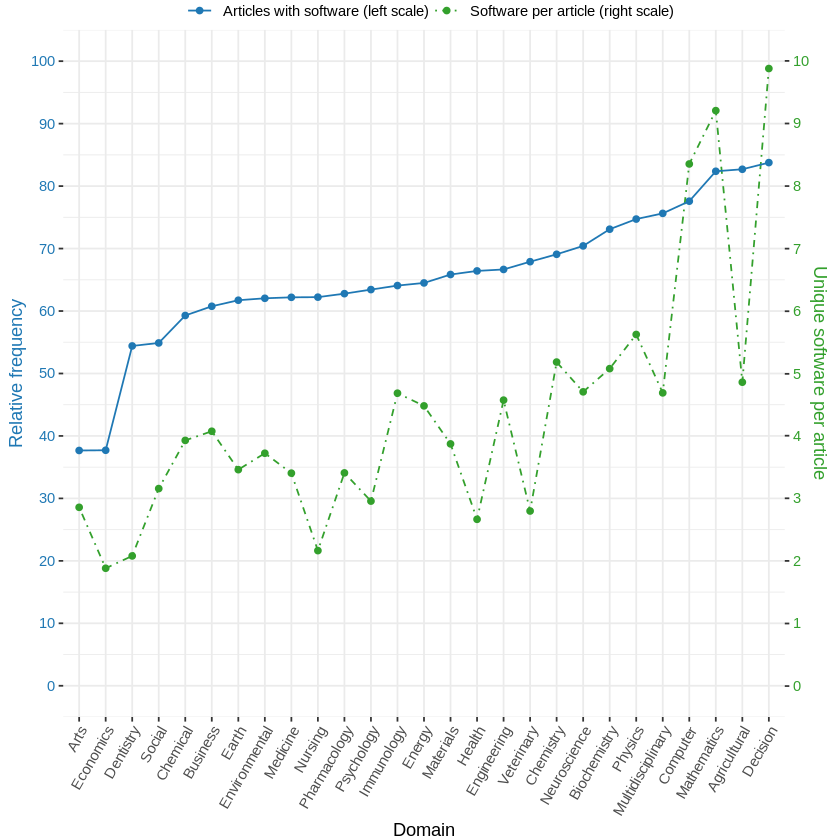

In [26]:
avg_software_per_category = run_and_cache("
SELECT
    AVG(xsd:float(?num_software)) as ?avg_software
    ?category
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT
        COUNT(DISTINCT ?software) as ?num_software
        ?article
        ?category
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
    
        ?article a schema:ScholarlyArticle ;
                 dct:isPartOf ?journal ;
                 schema:datePublished ?date;
                 schema:mentions/skgv:software ?software.

        ?journal dct:subject/skos:hasTopConcept/schema:name ?category.
}
    group by ?article ?category
}
group by ?category
")

# papers not mentioning software per research domain
query="
SELECT
    COUNT(DISTINCT ?article) as ?wo_software
    ?category
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle ;
             dct:isPartOf ?journal ;
             schema:datePublished ?date .
    ?journal dct:subject/skos:hasTopConcept/schema:name ?category.

    FILTER NOT EXISTS {
        ?article schema:mentions/skgv:software [].
    }
}
GROUP BY ?category
"
paper_wo_software_per_category = run_and_cache(query, cache.name="paper_wo_software_per_category")

# papers mentioning at least one software per research domain
query="
SELECT 
    COUNT(DISTINCT ?article) as ?with_software
    ?category
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{

    ?article a schema:ScholarlyArticle ;
             dct:isPartOf ?journal ;
             schema:datePublished ?date ;
             schema:mentions/skgv:software [].
    ?journal dct:subject/skos:hasTopConcept/schema:name ?category.
}
GROUP BY ?category"
paper_with_software_per_category = run_and_cache(query, cache.name="paper_with_software_per_category")

paper_with_software_per_category %>%
    full_join(paper_wo_software_per_category, by='category') %>%
    inner_join(avg_software_per_category, by='category') %>%
    replace(is.na(.), 0) %>%
    mutate(all=with_software+wo_software) %>%
    mutate(with_software=with_software*100/all) %>%
    mutate(avg_s = avg_software*100/10) %>%
    mutate(category=stringr::str_split(category, ",") %>% map_chr(., 1)) %>%
    mutate(category=stringr::str_split(category, " ") %>% map_chr(., 1)) %>%
    arrange(with_software) %>%
    mutate(category=factor(category, levels=category)) %>%
    pivot_longer(c('with_software', 'avg_s')) %>%
    ggplot(., aes(category, value)) +
        geom_point(aes(color=name)) +
        geom_line(aes(color=name, group=name, linetype=name)) +
        theme_sw() +
        theme(axis.text.x = element_text(angle=60, hjust=1)) +
        ylab('Relative frequency') +
        xlab('Domain') +
        scale_linetype_manual("", 
                           values=c("with_software"=1, 
                                    "avg_s"=4),
                          breaks=c("with_software", "avg_s"), 
                          labels=c("with_software"="Articles with software (left scale)", 
                                    "avg_s"="Software per article (right scale)")
                          ) +
        scale_color_manual("", 
                           values=c("with_software"="#1f78b4", 
                                    "avg_s"="#33a02c"),
                          breaks=c("with_software", "avg_s"), 
                          labels=c("with_software"="Articles with software (left scale)", 
                                    "avg_s"="Software per article (right scale)")
                          ) +
        scale_y_continuous(limits = c(0, 100), breaks = seq(0, 100, by = 10),
                           sec.axis = sec_axis(~ . *10/100, breaks=0:10, 
                                               name = "Unique software per article")) +
        theme(axis.text.y.left = element_text(color = "#1f78b4"), axis.title.y.left = element_text(color='#1f78b4'),
              axis.text.y.right = element_text(color = "#33a02c"),axis.title.y.right = element_text(color='#33a02c'),
                legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm")) -> 
p_articles_with_software_per_domain

ggsave(p_articles_with_software_per_domain, filename = 'articles_with_software_mentions_per_domain.png', 
       width=2600, height=1100, unit='px')
p_articles_with_software_per_domain

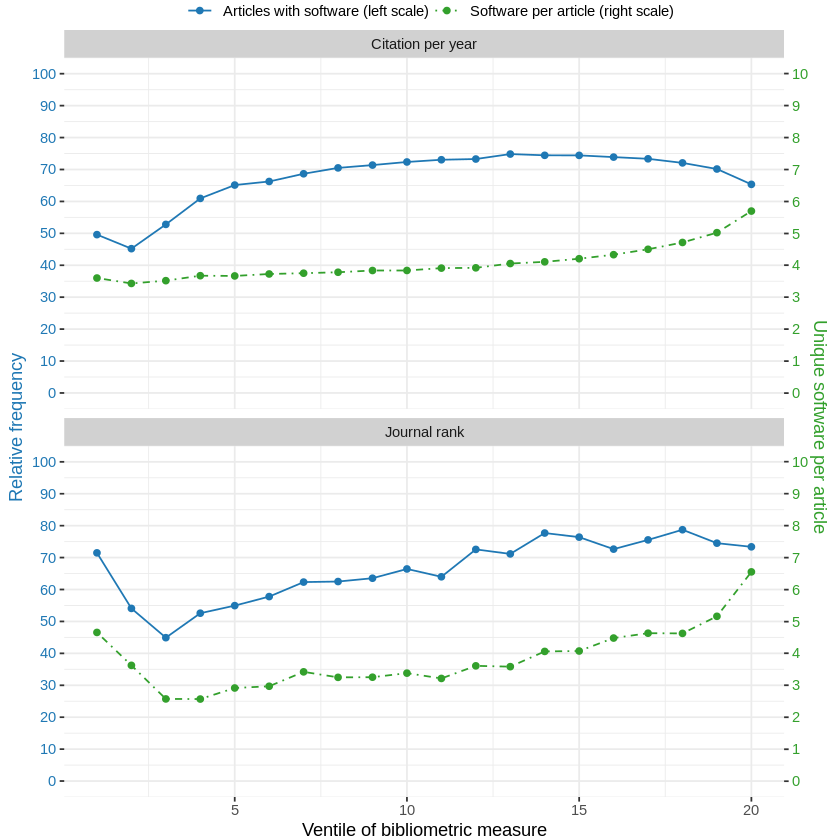

In [27]:
sum_software_per_journal = run_and_cache(query="
SELECT 
    SUM(?num_software) as ?sum_software
    COUNT(?article) as ?art_count
    ?journal
    year(?date) as ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT
        COUNT(DISTINCT ?software) as ?num_software
        ?article
        ?journal
        ?date
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
    
        ?article a schema:ScholarlyArticle ;
                 dct:isPartOf ?journal ;
                 schema:datePublished ?date;
                 schema:mentions/skgv:software ?software.

    }
    group by ?article ?journal ?date
}
GROUP BY ?journal year(?date)
", cache.name='sum_software_per_journal')

# papers per journal rank not mentioning software
papers_wo_software_per_journal = run_and_cache(query="
SELECT 
    COUNT(DISTINCT ?article) as ?wo_software
    ?journal
    year(?date) as ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle ;
             dct:isPartOf ?journal ;
             schema:datePublished ?date .

    FILTER NOT EXISTS {
        ?article schema:mentions/skgv:software [].
    }
}
GROUP BY ?journal year(?date)
", cache.name='papers_wo_software_per_journal')

# papers per journal rank mentioning at least one software
papers_with_software_per_journal = run_and_cache(query="
SELECT
    COUNT(DISTINCT ?article) as ?with_software
    ?journal
    year(?date) as ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle ;
             dct:isPartOf ?journal ;
             schema:datePublished ?date ;
             schema:mentions/skgv:software [].
}
GROUP BY ?journal year(?date)
", cache.name='papers_with_software_per_journal')

papers_with_software_per_journal %<>%
    distinct() %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(with_software=sum(with_software)) 

papers_wo_software_per_journal %<>%
    distinct() %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(wo_software=sum(wo_software))

sum_software_per_journal %<>%
    distinct() %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(software_sum=sum(sum_software), article_sum=sum(art_count)) %>%
    mutate(avg_software=software_sum/article_sum)

papers_with_software_per_journal %>%
    full_join(papers_wo_software_per_journal, by='rank_20') %>%
    full_join(sum_software_per_journal, by='rank_20') %>%
    mutate(all=with_software+wo_software) %>%
    mutate(with_software=with_software*100/all) %>%
    rename(journal=with_software) %>%
    select(rank_20, journal, avg_software)-> 
df_papers_with_software_per_journal

sum_software_per_citation_count = run_and_cache(query='
SELECT 
    ?domain
    ?citations_per_year
    SUM(?num_software) as ?sum_software
    COUNT(?article) as ?art_count
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT 
        COUNT(DISTINCT ?software) as ?num_software
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE
    {
        ?article skgv:citationCount ?citation_count ;
               schema:datePublished ?date ;
               schema:mentions/skgv:software ?software;
               dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        FILTER (year(?date) < 2020)
    } GROUP BY ?article ?domain ?date ?citation_count
}
GROUP BY ?domain ?citations_per_year
ORDER BY DESC(?citations_per_year)
', cache.name="sum_software_per_citation_count")

# papers with software per citation count 
paper_with_software_per_citation_count = run_and_cache(query='
SELECT 
    ?domain
    ?citations_per_year
    COUNT(?article) as ?article_count
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT 
    DISTINCT
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE
    {
        ?article skgv:citationCount ?citation_count ;
               schema:datePublished ?date ;
               schema:mentions/skgv:software [];
               dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        FILTER (year(?date) < 2020)
    }
}
GROUP BY ?domain ?citations_per_year
ORDER BY DESC(?citations_per_year)
', cache.name="paper_with_software_per_citation_count")

paper_wo_software_per_citation_count = run_and_cache(query='
SELECT 
    ?domain
    ?citations_per_year
    COUNT(?article) as ?article_count
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE {
    SELECT 
    DISTINCT
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE
    {
        ?article skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .

        FILTER NOT EXISTS {
            ?article schema:mentions/skgv:software [].
        }
        FILTER (year(?date) < 2020)
    }
}
GROUP BY ?domain ?citations_per_year
ORDER BY DESC(?citations_per_year)
', cache.name="paper_wo_software_per_citation_count_2")

paper_wo_software_per_citation_count %<>% rename(citations=citations_per_year)
paper_with_software_per_citation_count %<>% rename(citations=citations_per_year)
sum_software_per_citation_count %<>% rename(citations=citations_per_year)

paper_wo_software_per_citation_count %>%
    full_join(paper_with_software_per_citation_count, by=c('domain'='domain', 'citations'='citations')) %>%
    full_join(sum_software_per_citation_count, by=c('domain'='domain', 'citations'='citations')) %>%
    replace(is.na(.), 0) %>%
    rename(w_software=article_count.y, wo_software=article_count.x) %>%
    mutate(all=w_software+wo_software) ->
df_article_per_domain_citation_count

df_article_per_domain_citation_count %>%
    mutate(w_software=w_software/all, wo_software=wo_software/all, avg_software=sum_software/art_count) %>%
    replace(is.na(.), 0) %>%
    uncount(all) %>%
    group_by(domain) %>%
    mutate(rank_20=ntile(citations, 20)) %>%
    ungroup() %>%
    group_by(rank_20) %>%
    summarize(w_software=sum(w_software), wo_software=sum(wo_software), avg_s=mean(avg_software)) %>%
    ungroup() %>%
    mutate(all=w_software+wo_software) %>%
    mutate(w_software=w_software*100/all) %>%
    rename(citation=w_software) %>%
    select(rank_20, citation, avg_s) ->
df_paper_wo_software_per_citation_count

df_papers_with_software_per_journal %>%
    inner_join(df_paper_wo_software_per_citation_count, by='rank_20') %>%
    rename(avg_software_per_journal_rank=avg_software, avg_software_per_citation_count=avg_s) %>%
    mutate(avg_software_per_journal_rank=avg_software_per_journal_rank*100/10, 
           avg_software_per_citation_count=avg_software_per_citation_count*100/10) %>%
    pivot_longer(c('journal', 'avg_software_per_journal_rank', 'citation', 'avg_software_per_citation_count')) %>%
    mutate(source=factor(ifelse(startsWith(name, 'avg'), 'Software', 'Article')), 
           measure=factor(ifelse(str_detect(name, 'journal'),'Journal rank','Citation per year'))) %>%
    ggplot(., aes(rank_20, value)) +
        geom_point(aes(color=source)) +
        geom_line(aes(color=source, linetype=source)) +
        #scale_shape_manual(values=c(10,10,35,17)) +
        scale_linetype_manual("", 
                           values=c("Article"=1, 
                                    "Software"=4),
                          labels=c("Article"="Articles with software (left scale)", 
                                    "Software"="Software per article (right scale)")
                          ) +
        scale_color_manual("", 
                           values=c("Article"="#1f78b4", 
                                    "Software"="#33a02c"),
                          labels=c("Article"="Articles with software (left scale)", 
                                    "Software"="Software per article (right scale)")
                          ) +
        theme_sw() +
        xlab('Ventile of bibliometric measure') +
        ylab('Relative frequency') +
        scale_y_continuous(limits = c(0, 100), 
                           breaks = seq(0, 100, by = 10),
                           sec.axis = sec_axis(~ . *10/100, breaks=0:10, 
                                               name = "Unique software per article")) +
        theme(axis.text.y.left = element_text(color = "#1f78b4"), axis.title.y.left = element_text(color='#1f78b4'),
              axis.text.y.right = element_text(color = "#33a02c"),axis.title.y.right = element_text(color='#33a02c'),,
                legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm"))+
facet_wrap(~measure, nrow=2) ->
#        facet_wrap(~gr, nrow=2, labeller = function(v,v2){return('Articles  with software per ventile of bibliometric measure')}) ->
p_articles_with_software_per_bibliometric_measures 

ggsave(p_articles_with_software_per_bibliometric_measures, 
       filename = 'articles_with_software_mentions_per_bibliometric_measure.png', width=8, height=5.25)
p_articles_with_software_per_bibliometric_measures

# Completeness

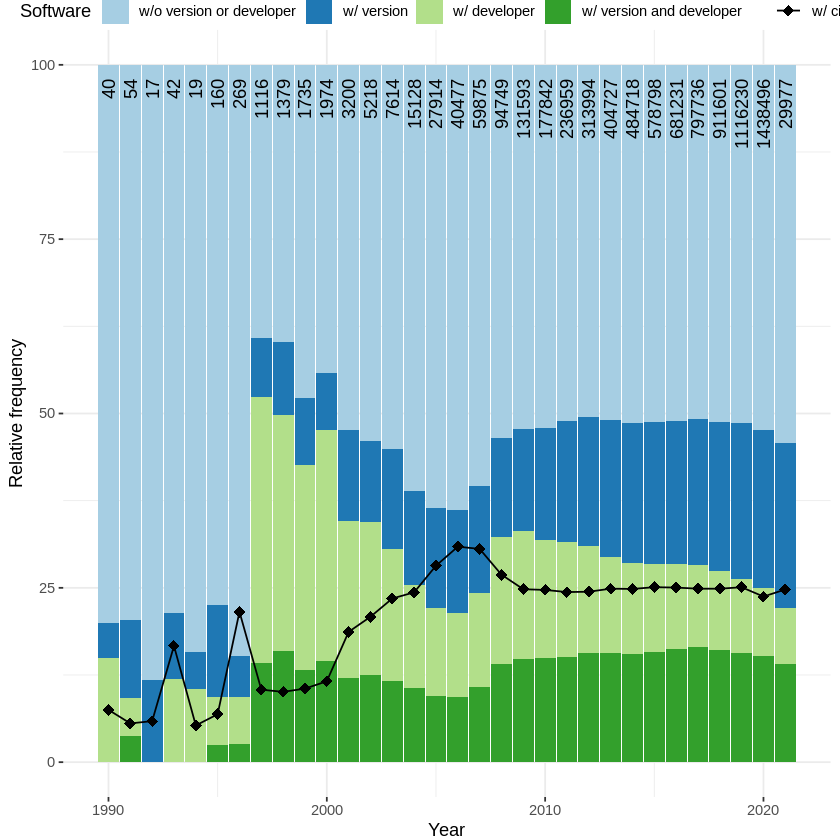

In [28]:
# WARNING: THIS IS A WORKING WOKPY FROM THE NEXT CELL

software_year = run_and_cache(query="
SELECT
    ?year
    SUM(?num_software) as ?n_software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                    schema:datePublished ?date.
            FILTER (year(?date) >= 1990)
            ?mention skgv:software ?software.

            FILTER NOT EXISTS {
                ?article schema:mentions ?mention_w_developer.
                ?mention_w_developer skgv:software ?software.
                ?mention_w_developer skgv:referredToByDeveloper [] .
            }

            FILTER NOT EXISTS {
                ?article schema:mentions ?mention_w_version.
                ?mention_w_version skgv:software ?software.
                ?mention_w_version skgv:referredToByVersion [] .
            }

        } GROUP BY ?article year(?date)
    }
} GROUP BY ?year",cache.name="unique_software_mentions_per_year")


software_version_year = run_and_cache(query="
SELECT
    ?year
    SUM(?num_software) as ?n_version
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:datePublished ?date.

            ?mention skgv:software ?software.

            ?mention skgv:referredToByVersion [].

            FILTER (year(?date) >= 1990)
            MINUS {
                ?article schema:mentions ?mention_w_developer.
                ?mention_w_developer skgv:software ?software.
                ?mention_w_developer skgv:referredToByDeveloper [] .
            }

        } GROUP BY ?article year(?date)
    }
} GROUP BY ?year", cache.name="unique_software_version_mentios_per_year")


software_developer_year = run_and_cache(query="
SELECT
    ?year
    SUM(?num_software) as ?n_developer
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:datePublished ?date.
            FILTER (year(?date) >= 1990)
            ?mention skgv:software ?software.
            ?mention skgv:referredToByDeveloper [].

            MINUS {
                ?article schema:mentions ?mention_w_version.
                ?mention_w_version skgv:software ?software.
                ?mention_w_version skgv:referredToByVersion [] .
            }
        } GROUP BY ?article year(?date)
    }
} GROUP BY ?year", cache.name="unique_software_developer_mentios_per_year")


software_dev_ver_year = run_and_cache(query="
SELECT
    ?year
    SUM(?num_software) as ?n_version_dev
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                    schema:mentions ?mention2;
                    schema:datePublished ?date.
            FILTER (year(?date) >= 1990)
            ?mention skgv:software ?software.
            ?mention2 skgv:software ?software.
            ?mention skgv:referredToByDeveloper [].
            ?mention2 skgv:referredToByVersion [].
        } GROUP BY ?article year(?date)
    }
} GROUP BY ?year", cache.name="unique_software_dev_ver_mentios_per_year")

software_citation_year = run_and_cache(query="
SELECT
    ?year
    (SUM(?num_software) as ?n_citation)
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                    schema:datePublished ?date.
            FILTER (year(?date) >= 1990)
            ?mention skgv:software ?software.
            ?mention skgv:referredToByCitation [].

        } GROUP BY ?article year(?date)
    }
} GROUP BY ?year", cache.name="unique_software_citation_mentios_per_year")

sw_year <- c(sum(software_year$n_software),
             sum(software_version_year$n_version),

sum(software_developer_year$n_developer),
sum(software_dev_ver_year$n_version_dev))

software_year %>%
    left_join(software_version_year, by='year') %>%
    left_join(software_developer_year, by ='year') %>%
    left_join(software_dev_ver_year, by='year') %>%
    left_join(software_citation_year, by ='year') %>%
    replace(is.na(.), 0) %>%    
    mutate(all = n_software + n_version + n_developer + n_version_dev) %>%
    pivot_longer(c('n_software', 'n_version', 'n_developer', 'n_version_dev')) %>%
    mutate(value = value/all, 
           n_citation=n_citation/all,
          name = factor(name, levels=c('n_software','n_version', 'n_developer', 'n_version_dev'))) ->
df 

df %>%
select(year,all) %>%
distinct()->
df_np


df %>%
    ggplot(., aes(year, value*100)) + 
    geom_bar(aes(fill=name), stat='identity',width=.95) + 
    geom_point(aes(year, n_citation*100, color=factor(1)), shape=18, size=3) +
    geom_line(aes(year, n_citation*100, color=factor(1))) +
    geom_text(aes(year,98,label=all,fill = NULL), vjust=.5, hjust=1, angle=90, data=df_np)+ 
    scale_fill_manual(name='Software', 
                      values=c("#a6cee3","#1f78b4", "#b2df8a", "#33a02c"),
                      labels=c('n_software'='w/o version or developer', 
                               'n_developer'='w/ developer',
                               'n_version'='w/ version',
                               'n_version_dev'='w/ version and developer')) +
    
    scale_colour_manual(" ", values=c('black'), labels="w/ citation", guide = "legend") +
    theme_sw() +
    theme(legend.position = 'top', ,
                legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm")) +
    ylab("Relative frequency") + xlab("Year") +
    guides(fill=guide_legend(nrow=1, byrow=TRUE, order=1), color=guide_legend(order=2)) ->

    p_software_year

ggsave('software_and_add_info_per_year.png', p_software_year, width=8.5, height=3.3)
p_software_year

When it comes to software mention completeness it is also important to look at how many articles include formal citations for software. 

The second set of research questions focuses on software with respect to the underlying scientific domain. 

2. Software over research domain

    2.1 Which domains do mention the most software?
    
    2.2 How complete are software mentions within different domains?
    
    2.3 Do different research domains use specific software?

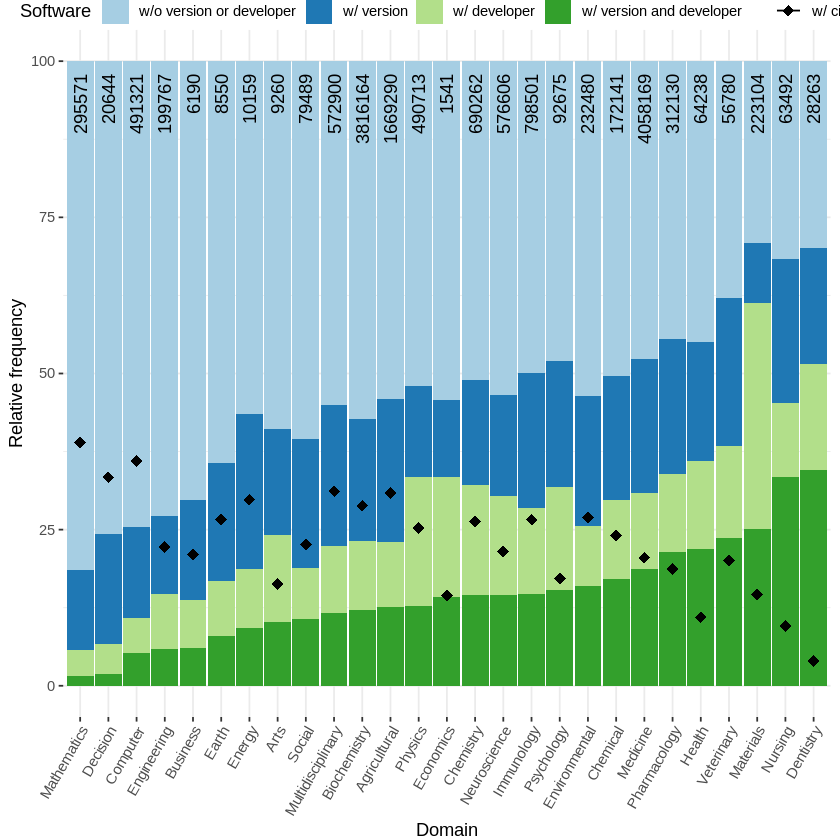

In [29]:
software_concept = run_and_cache(query="
SELECT
    ?concept
    SUM(?num_software) as ?n_software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?concept
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                    dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 
            ?mention skgv:software ?software.
           
            FILTER NOT EXISTS { 
                ?article schema:mentions ?v_mention.
                ?v_mention skgv:software ?software.
                ?v_mention skgv:referredToByVersion [].
            }
            FILTER NOT EXISTS { 
                ?article schema:mentions ?d_mention.
                ?d_mention skgv:software ?software.
                ?d_mention skgv:referredToByDeveloper [].
            }

        } GROUP BY ?article ?concept
    }
} GROUP BY ?concept",cache.name="unique_software_mentions_per_concept")

software_version_concept = run_and_cache(query="
SELECT
    ?concept
    SUM(?num_software) as ?n_version
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?concept
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 

            ?mention skgv:software ?software.
            ?mention skgv:referredToByVersion [].

            FILTER NOT EXISTS { 
                ?article schema:mentions ?d_mention.
                ?d_mention skgv:software ?software.
                ?d_mention skgv:referredToByDeveloper []
            }

        } GROUP BY ?article ?concept
    }
} GROUP BY ?concept", cache.name="unique_software_version_mentios_per_concept")

software_developer_concept = run_and_cache(query="
SELECT
    ?concept
    SUM(?num_software) as ?n_developer
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
    {
        SELECT
            ?article
            ?concept
            COUNT(DISTINCT ?software) as ?num_software 
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 

            ?mention skgv:software ?software.
            ?mention skgv:referredToByDeveloper [].

            FILTER NOT EXISTS { 
                ?article schema:mentions ?v_mention.
                ?v_mention skgv:software ?software.
                ?v_mention skgv:referredToByVersion []
            }
        } GROUP BY ?article ?concept
    }
} GROUP BY ?concept", cache.name="unique_software_developer_mentios_per_concept")

software_dev_ver_concept = run_and_cache(query="
SELECT
    ?concept
    SUM(?num_software) as ?n_version_dev
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
    SELECT
        ?article
        ?concept
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE
    {
        ?article schema:mentions ?mention;
                 schema:mentions ?mention2;
                 dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 
        
        ?mention skgv:software ?software.
        ?mention skgv:referredToByDeveloper [].
        
        ?mention2 skgv:software ?software.
        ?mention2 skgv:referredToByVersion [].
    } GROUP BY ?article ?concept
    }
} GROUP BY ?concept", cache.name="unique_software_dev_ver_mentios_per_concept")

software_citation_concept = run_and_cache(query="
PREFIX schema: <http://schema.org/>
PREFIX nif: <http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#>
PREFIX skg: <http://data.gesis.org/softwarekg2/>
PREFIX dct: <http://purl.org/dc/terms/>

SELECT
    ?concept
    SUM(?num_software) as ?n_citation
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
    SELECT
        ?article
        ?concept
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
        ?article schema:mentions ?mention.
        ?article dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 

        ?mention skgv:software ?software.
        ?mention skgv:referredToByCitation [].
    } GROUP BY ?article ?concept
    }
} GROUP BY ?concept", cache.name="unique_software_citation_mentios_per_concept")

sw_concept <- c(sum(software_concept$n_software),
                    sum(software_version_concept$n_version),
                    sum(software_developer_concept$n_developer),
                    sum(software_dev_ver_concept$n_version_dev))


software_concept %>%
    left_join(software_version_concept, by='concept') %>%
    left_join(software_developer_concept, by ='concept') %>%
    left_join(software_dev_ver_concept, by='concept') %>%
    left_join(software_citation_concept, by='concept') %>%
    mutate(all = n_software + n_version + n_developer + n_version_dev) %>%
    mutate(sort =n_version_dev/all) %>%
    pivot_longer(c( 'n_version', 'n_developer', 'n_version_dev','n_software')) %>%
    mutate(name =factor(name, levels=rev(c('n_version_dev', 'n_developer', 'n_version', 'n_software')))) %>%
    mutate(value = value/all) %>%
    mutate(concept=stringr::str_split(concept, ",") %>% map_chr(., 1)) %>%
    mutate(concept=stringr::str_split(concept, " ") %>% map_chr(., 1))%>%
    #mutate(concept = factor(concept, levels=order_category)) %>%
    replace(is.na(.), 0) -> 
    df


df %>%
select(concept,all) %>%
distinct() ->
df_np

df %>%
    ggplot(., aes(reorder(concept,sort), value*100)) + 
    geom_bar(aes(fill=name), stat='identity', width=.95) + 
    geom_point(aes(concept, n_citation*100/all, color=factor(1)), shape=18, size=3) +
    
geom_line(aes(concept, n_citation*100/all, color=factor(1), group=concept)) +
    geom_text(aes(concept,98,label=all,fill = NULL), vjust=.5, hjust=1, angle=90, data=df_np)+ 
    scale_fill_manual(name='Software', 
                      values=c("#a6cee3","#1f78b4", "#b2df8a", "#33a02c"),
                      labels=c('n_software'='w/o version or developer', 
                               'n_developer'='w/ developer',
                               'n_version'='w/ version',
                               'n_version_dev'='w/ version and developer')) +
    theme_sw() +
    theme(axis.text.x = element_text(angle=60, hjust=1), legend.position = 'top',,
                legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm")) +
    ylab("Relative frequency") + xlab("Domain") +
    guides(fill=guide_legend(nrow=1, byrow=TRUE, order=1), color=guide_legend(order=2))  +
    scale_colour_manual(" ", values=c('black'), labels="w/ citation", guide = "legend") ->

    p_software_per_category

ggsave('software_and_add_info_per_concept.png', p_software_per_category, width=8.5, height=4.2)
p_software_per_category

Now we look at formal software citations per domain.

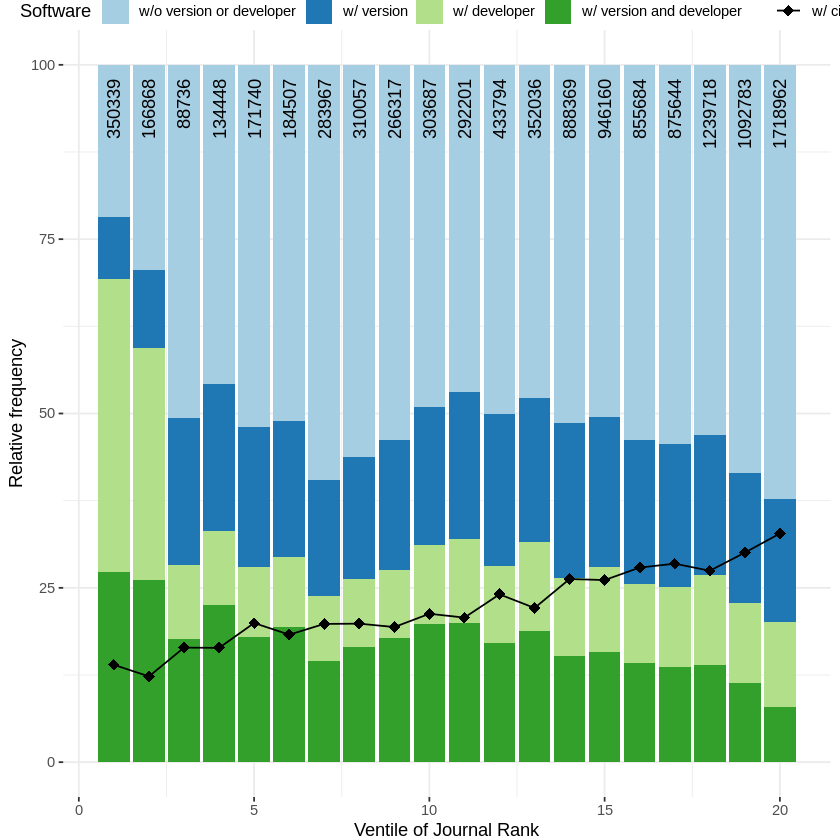

In [30]:
software_rank = run_and_cache(query="
SELECT
    ?journal
    ?year
    SUM(?num_software) as ?n_software
    COUNT(DISTINCT ?article) as ?x
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?journal
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software 
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:datePublished ?date;
                     dct:isPartOf ?journal .

            ?mention skgv:software ?software.
            FILTER NOT EXISTS { 
                ?article schema:mentions ?v_mention.
                ?v_mention skgv:software ?software.
                ?v_mention skgv:referredToByVersion []
            }
            FILTER NOT EXISTS { 
                ?article schema:mentions ?d_mention.
                ?d_mention skgv:software ?software.
                ?d_mention skgv:referredToByDeveloper []
            }

        } GROUP BY ?article year(?date) ?journal
    }
} GROUP BY ?journal ?year",cache.name="unique_software_mentions_per_concept")

software_version_rank = run_and_cache(query="
SELECT
    ?journal
    ?year
    SUM(?num_software) as ?n_software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?journal
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software 
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:datePublished ?date;
                     dct:isPartOf ?journal .

            ?mention skgv:software ?software.
            ?mention skgv:referredToByVersion [].

            FILTER NOT EXISTS { 
                ?article schema:mentions ?d_mention.
                ?d_mention skgv:software ?software.
                ?d_mention skgv:referredToByDeveloper []
            }

        } GROUP BY ?article year(?date) ?journal
    }
} GROUP BY ?journal ?year
", cache.name="unique_software_version_mentios_per_concept")



software_developer_rank = run_and_cache(query="
SELECT
    ?journal
    ?year
    SUM(?num_software) as ?n_software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?journal
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software 
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:datePublished ?date;
                     dct:isPartOf ?journal .

            ?mention skgv:software ?software.
            ?mention skgv:referredToByDeveloper [].

            FILTER NOT EXISTS { 
                ?article schema:mentions ?v_mention.
                ?v_mention skgv:software ?software.
                ?v_mention skgv:referredToByVersion []
            }

        } GROUP BY ?article year(?date) ?journal
    }
} GROUP BY ?journal ?year
", cache.name="unique_software_developer_mentios_per_concept")


software_dev_ver_rank = run_and_cache(query="
SELECT
    ?journal
    ?year
    SUM(?num_software) as ?n_software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?journal
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:mentions ?mention2;
                     schema:datePublished ?date;
                     dct:isPartOf ?journal .

            ?mention skgv:software ?software;
                     skgv:referredToByDeveloper [].

            ?mention2 skgv:software ?software;
                      skgv:referredToByVersion [].

        } GROUP BY ?article year(?date) ?journal
    }
} GROUP BY ?journal ?year
", cache.name="unique_software_dev_ver_mentios_per_concept")

sw_rank <- c(sum(software_rank$n_software),
sum(software_version_rank$n_software),
sum(software_developer_rank$n_software),
    sum(software_dev_ver_rank$n_software)
)

software_citation_rank = run_and_cache(query="

SELECT
    ?journal
    ?year
    SUM(?num_software) as ?n_software
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    {
        SELECT
            ?article
            ?journal
            year(?date) as ?year
            COUNT(DISTINCT ?software) as ?num_software
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE
        {
            ?article schema:mentions ?mention;
                     schema:datePublished ?date;
                     dct:isPartOf ?journal .

            ?mention skgv:software ?software;
                     skgv:referredToByCitation [].
        } GROUP BY ?article year(?date) ?journal
    }
} GROUP BY ?journal ?year

", cache.name="unique_software_citation_mentios_per_concept")

software_rank %<>%
    distinct() %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(n_software=sum(n_software)) 

software_version_rank %<>%
    distinct() %>%
    rename(n_version=n_software) %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(n_version=sum(n_version))

software_developer_rank %<>%
    distinct() %>%
    rename(n_developer = n_software) %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(n_developer=sum(n_developer))

software_dev_ver_rank %<>%
    distinct() %>%
    rename(n_dev_ver = n_software) %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(n_dev_ver=sum(n_dev_ver))

software_citation_rank %<>%
    distinct() %>%
    rename(n_citation = n_software) %>%
    inner_join(journal_rank_percentile, by=c("journal"="journal", "year"="year")) %>%
    group_by(rank_20) %>%
    summarise(n_citation=sum(n_citation))

software_rank %>%
    full_join(software_version_rank, by='rank_20')%>%
    full_join(software_developer_rank, by='rank_20')%>%
    full_join(software_dev_ver_rank, by='rank_20')%>%
    full_join(software_citation_rank, by='rank_20')%>%
    replace(is.na(.), 0) %>%
    mutate(all = n_software + n_version + n_developer + n_dev_ver) %>%
    pivot_longer(c('n_software','n_version', 'n_developer', 'n_dev_ver')) %>%
    mutate(value=value*100/all) %>%
    mutate(n_citation = n_citation*100/all) %>%
    mutate(name = factor(name, levels=c('n_software', 'n_version', 'n_developer', 'n_dev_ver'))) %>%
    rename(percentile=rank_20) ->
df

df %>% 
    select(percentile,all) %>%
    distinct() ->
    df_np

    ggplot(df, aes(percentile,value)) + 
        geom_bar(aes(fill=name), stat='identity') + 
        geom_point(aes(percentile, n_citation, color=factor(1)), shape=18, size=3) +
        geom_line(aes(percentile, n_citation, color=factor(1))) +
        geom_text(aes(percentile,98,label=all,fill = NULL), vjust=.5, hjust=1, angle=90, data=df_np)+ 
        scale_fill_manual(name='Software', 
                      values=c("#a6cee3","#1f78b4", "#b2df8a", "#33a02c"),
                      labels=c('n_software'='w/o version or developer', 
                               'n_developer'='w/ developer',
                               'n_version'='w/ version',
                               'n_dev_ver'='w/ version and developer')) +

        xlab("Ventile of Journal Rank") + ylab("Relative frequency") +
        theme_sw() +
        theme(legend.position = 'top',,
                legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm")) +
        guides(fill=guide_legend(nrow=1, byrow=TRUE, order=1), color=guide_legend(order=2)) +
        scale_colour_manual(" ", values=c('black'), labels="w/ citation", guide = "legend")->
p_software_per_rank

ggsave('software_and_add_info_per_rank.png', p_software_per_rank, width=8.5, height=3.4)
p_software_per_rank

# Software vs. Citation

In [31]:
software_per_citation = run_and_cache(query="
SELECT
    ?domain
    ?citations_per_year
    SUM(?num_software) as ?n_software
    COUNT(DISTINCT ?article) as ?num_articles
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT 
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
        ?article schema:mentions ?mention;
                 skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        
        ?mention skgv:software ?software.
        FILTER NOT EXISTS { 
            ?article schema:mentions ?v_mention.
            ?v_mention skgv:software ?software.
            ?v_mention skgv:referredToByVersion []
        }
        FILTER NOT EXISTS { 
            ?article schema:mentions ?d_mention.
            ?d_mention skgv:software ?software.
            ?d_mention skgv:referredToByDeveloper []
        }
        FILTER (year(?date) < 2020)
    } GROUP BY ?article ?domain ?citation_count ?date
} GROUP BY ?domain ?citations_per_year", cache.name="software_per_citation")


software_with_version_per_citation = run_and_cache(query="
SELECT
    ?domain
    ?citations_per_year
    SUM(?num_software) as ?n_version
    COUNT(DISTINCT ?article) as ?num_articles
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT 
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
        ?article schema:mentions ?mention;
                 skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        
        ?mention skgv:software ?software;
                 skgv:referredToByVersion [].

        FILTER NOT EXISTS { 
            ?article schema:mentions ?d_mention.
            ?d_mention skgv:software ?software.
            ?d_mention skgv:referredToByDeveloper []
        }
        FILTER (year(?date) < 2020)
    } GROUP BY ?article ?domain ?citation_count ?date
} GROUP BY ?domain ?citations_per_year", cache.name="software_with_version_per_citation")


software_with_developer_per_citation = run_and_cache(query="
SELECT
    ?domain
    ?citations_per_year
    SUM(?num_software) as ?n_developer
    COUNT(DISTINCT ?article) as ?num_articles
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT 
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
        ?article schema:mentions ?mention;
                 skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        
        ?mention skgv:software ?software;
                  skgv:referredToByDeveloper [].

        FILTER NOT EXISTS { 
            ?article schema:mentions ?v_mention.
            ?v_mention skgv:software ?software.
            ?v_mention skgv:referredToByVersion []
        }
        
        FILTER (year(?date) < 2020)
    } GROUP BY ?article ?domain ?citation_count ?date
} GROUP BY ?domain ?citations_per_year", cache.name="software_with_developer_per_citation")


software_with_dev_ver_per_citation = run_and_cache(query="
SELECT
    ?domain
    ?citations_per_year
    SUM(?num_software) as ?n_dev_ver
    COUNT(DISTINCT ?article) as ?num_articles
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    SELECT 
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
        ?article schema:mentions ?mention;
                 schema:mentions ?mention2;
                 skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        
        ?mention skgv:software ?software;
                 skgv:referredToByVersion [].

        ?mention2 skgv:software ?software;
                 skgv:referredToByDeveloper [].
        FILTER (year(?date) < 2020)
    } GROUP BY ?article ?domain ?citation_count ?date
} GROUP BY ?domain ?citations_per_year", cache.name="software_with_dev_ver_per_citation")

art_citation <- c(sum(software_per_citation$num_articles),
                 sum(software_with_version_per_citation$num_articles),
                 sum(software_with_developer_per_citation$num_articles),
                sum(software_with_dev_ver_per_citation$num_articles))


sw_citation <- c(sum(software_per_citation$n_software),
                 sum(software_with_version_per_citation$n_version),
                 sum(software_with_developer_per_citation$n_developer),
                sum(software_with_dev_ver_per_citation$n_dev_ver))


software_with_citation_per_citation = run_and_cache(query="
SELECT
    ?domain
    ?citations_per_year
    SUM(?num_software) as ?n_citation
    COUNT(DISTINCT ?article) as ?num_articles
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
    SELECT 
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
        COUNT(DISTINCT ?software) as ?num_software 
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE{
        ?article schema:mentions ?mention;
                 skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .
        
        ?mention skgv:software ?software;
                 skgv:referredToByCitation []. 

        FILTER (year(?date) < 2020)
    } GROUP BY ?article ?domain ?citation_count ?date
} GROUP BY ?domain ?citations_per_year", cache.name="software_per_citation")

paper_wo_software_per_citation_count = run_and_cache(query='
SELECT 
    ?domain
    ?citations_per_year
    COUNT(DISTINCT ?article) as ?article_count
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE 
{
    SELECT 
    DISTINCT
        ?article
        ?domain
        xsd:int(round((xsd:float(?citation_count)/(2021-year(?date)))*100)) as ?citations_per_year
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE
    {
        ?article skgv:citationCount ?citation_count ;
                 schema:datePublished ?date ;
                 dct:isPartOf/dct:subject/skos:hasTopConcept ?domain .

        FILTER NOT EXISTS {
            ?article schema:mentions/skgv:software [].
        }
        FILTER (year(?date) < 2020)
    }
}
GROUP BY ?domain ?citations_per_year
ORDER BY DESC(?citations_per_year)
', cache.name="paper_wo_software_per_citation_count_2")

software_per_citation %<>% rename(n_software_art = num_articles)
software_with_version_per_citation %<>% rename(n_version_art = num_articles)
software_with_developer_per_citation %<>% rename(n_dev_art = num_articles)
software_with_dev_ver_per_citation %<>% rename(n_dev_ver_art = num_articles)
software_with_citation_per_citation %<>% rename(n_citation_art = num_articles)


software_per_citation %>%
    full_join(software_with_version_per_citation, by=c('domain'='domain', 'citations_per_year'='citations_per_year')) %>%
    full_join(software_with_developer_per_citation, by=c('domain'='domain', 'citations_per_year'='citations_per_year')) %>%
    full_join(software_with_dev_ver_per_citation, by=c('domain'='domain', 'citations_per_year'='citations_per_year')) %>%
    full_join(software_with_citation_per_citation, by=c('domain'='domain', 'citations_per_year'='citations_per_year')) %>%
    full_join(paper_wo_software_per_citation_count, by=c('domain'='domain', 'citations_per_year'='citations_per_year')) %>%
    replace(is.na(.), 0) %>%
    select(-n_software_art, -n_version_art, -n_dev_art, -n_dev_ver_art, -n_citation_art, -article_count) ->
    df_citation

head(df_citation)

domain,citations_per_year,n_software,n_version,n_developer,n_dev_ver,n_citation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,383,2218,957,696,983,1016
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,521,49,15,13,21,28
<http://data.gesis.org/softwarekg/PMC/conceptscheme/22>,425,292,154,114,166,139
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,250,35038,16608,9239,14706,16008
<http://data.gesis.org/softwarekg/PMC/conceptscheme/12>,0,16073,2384,1354,744,4707
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,200,70279,34454,19191,31596,31874


In [32]:
df_citation %>%
    inner_join(df_article_per_domain_citation_count, by = c("domain" = "domain", "citations_per_year" = "citations")) %>%
    select(-w_software,-wo_software) %>%
    rename(num_paper = all) %>%
    replace(is.na(.), 0) %>%
    mutate(all = n_software + n_version + n_developer + n_dev_ver) %>%
    mutate(n_software = n_software/all,
           n_version= n_version/all,
           n_developer = n_developer/all,
           n_dev_ver =n_dev_ver/all,
          n_citation =n_citation/all, 
          all_2=sum(all),
          np = all/num_paper) %>%
    uncount(num_paper) %>%
    group_by(domain) %>%
    mutate(rank_20 = ntile(citations_per_year, 20)) %>%
    ungroup() %>%
    filter(all!=0) ->
    ddf

#head(ddf)
#ddf



ddf %>%
    group_by(rank_20) %>%
    summarise(np = round(sum(np), digit=0)) ->
software_per_rank


#software_per_rank

ddf %>%
    group_by(rank_20) %>%
    summarise(with_software_m=mean(n_software), 
              with_version_m=mean(n_version), 
              with_developer_m=mean(n_developer), 
              with_version_and_developer_m=mean(n_dev_ver), 
              with_citation = mean(n_citation)
              ) %>%
    pivot_longer(c('with_software_m', 'with_version_m', 'with_developer_m', 'with_version_and_developer_m')) %>%
    mutate(name=factor(name, levels=c('with_software_m','with_version_m', 'with_developer_m', 'with_version_and_developer_m'))) %>%
    mutate(value=value*100) ->
df

df %<>%
inner_join(software_per_rank, by ="rank_20")

head(df)

rank_20,with_citation,name,value,np
<int>,<dbl>,<fct>,<dbl>,<dbl>
1,0.2214563,with_software_m,53.53849,405225
1,0.2214563,with_version_m,19.56103,405225
1,0.2214563,with_developer_m,11.50002,405225
1,0.2214563,with_version_and_developer_m,15.40046,405225
2,0.2183414,with_software_m,54.74051,365812
2,0.2183414,with_version_m,18.64611,365812


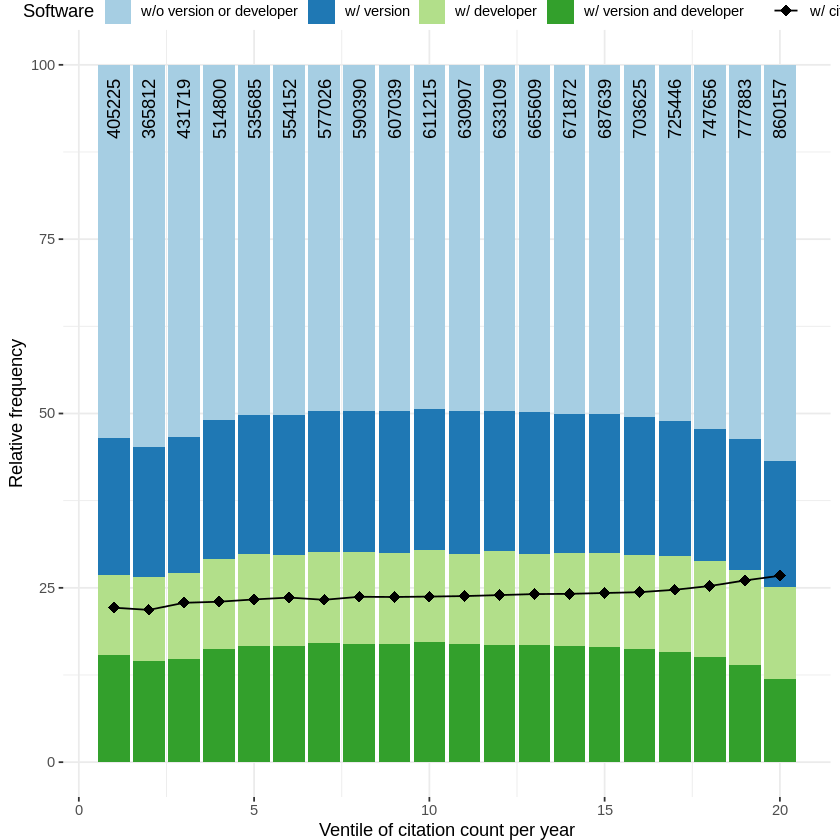

In [33]:
df %>%
    select(rank_20, np)%>%
    distinct() ->
df_np


df %>%
    ggplot(., aes(rank_20,value)) + 
        geom_bar(aes(fill=name), stat='identity') + 
        geom_text(aes(rank_20,98,label=np,fill = NULL), vjust=.5, hjust=1, angle=90, data=df_np)+ 
        geom_point(aes(rank_20, with_citation*100, color=factor(1)), shape=18, size=3) +
        geom_line(aes(rank_20, with_citation*100, color=factor(1))) +       
        scale_fill_manual(name='Software', 
                      values=c("#a6cee3","#1f78b4", "#b2df8a", "#33a02c"),
                      labels=c('with_software_m'='w/o version or developer', 
                               'with_developer_m'='w/ developer',
                               'with_version_m'='w/ version',
                               'with_version_and_developer_m'='w/ version and developer')) + 
        xlab("Ventile of citation count per year") + ylab("Relative frequency") +
        theme_sw() + 
        theme(legend.position='top', legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm"))+
        guides(fill=guide_legend(nrow=1, byrow=TRUE, order=1), color=guide_legend(order=2)) +
        scale_colour_manual("", values=c('black'), labels="w/ citation", guide = "legend")-> 
p
ggsave('software_and_add_info_per_citation_count.png', p, width=8.5, height=3.7)
p

In [34]:
head(software_with_version_per_citation)

domain,citations_per_year,n_version,n_version_art
<chr>,<dbl>,<dbl>,<dbl>
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,250,16608,8858
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,200,34454,19041
<http://data.gesis.org/softwarekg/PMC/conceptscheme/2>,57,2332,1232
<http://data.gesis.org/softwarekg/PMC/conceptscheme/0>,275,2111,957
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,169,132,90
<http://data.gesis.org/softwarekg/PMC/conceptscheme/18>,267,7593,4148


## Mention Type and Software Type

In [35]:
type_for_software = run_and_cache(query="
SELECT
    ?type
    COUNT(DISTINCT ?sw) as ?c
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
     SELECT 
        ?sw 
        ?type 
        ?max_ratio
    FROM 
        <http://data.gesis.org/softwarekg2> 
    WHERE
    {
        {
            SELECT 
                ?sw 
                MAX(?ratio) AS ?max_ratio
            FROM 
                <http://data.gesis.org/softwarekg2> 
            WHERE
            {
                ?stmt a rdf:Statement ;
                      rdf:subject ?sw ;
                      rdf:predicate skgv:softwareType ;
                      skgv:confidence ?ratio .
            }
            GROUP BY ?sw
        }

        ?stmt a rdf:Statement ;
              rdf:subject ?sw ;
              rdf:predicate skgv:softwareType ;
              rdf:object ?type ;
              skgv:confidence ?max_ratio .
    }
}
group by ?type", cache.name="type_for_software")

In [36]:
mention_vs_software = run_and_cache(query="
SELECT
    xsd:float(count(DISTINCT ?mention))*100/xsd:float(?num_all_mentions) as ?num_rel_mention
    ?softwareType 
    ?mentionType
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE {
    ?article schema:mentions ?mention.
    ?mention skgv:software ?software ;
             skgv:softwareType ?softwareType;
             skgv:mentionType ?mentionType.
    { 
        SELECT 
            COUNT(DISTINCT ?m) as ?num_all_mentions
        FROM 
            <http://data.gesis.org/softwarekg2> 
        WHERE { 
            ?m skgv:software ?s;
                skgv:softwareType ?softwareType;
                skgv:mentionType ?mentionType.
        }
    }
}
GROUP BY ?softwareType ?mentionType ?num_all_mentions
", cache.name="mention_vs_software")

library(stringr)
mention_vs_software %>%
    mutate_at("mentionType", str_replace, "<http://data.gesis.org/softwarekg/vocab/MentionType_", "") %>%
    mutate_at("softwareType",str_replace, "<http://data.gesis.org/softwarekg/vocab/", "")  %>%
    mutate_all(str_replace,">","") %>%
   spread(mentionType, num_rel_mention)  

softwareType,Allusion,Creation,Deposition,Usage
<chr>,<chr>,<chr>,<chr>,<chr>
Application,13.9455,1.83342,0.56314,68.1493
OperatingSystem,0.261661,2.5844e-05,0.000172293,1.69107
PlugIn,0.473978,0.174223,0.0371808,5.58376
ProgrammingEnvironment,0.404053,0.000353201,0.000904539,6.88122


Domain differences in mention type

concept,mtype,num_article,num_mention,num_software
<chr>,<chr>,<dbl>,<dbl>,<dbl>
Social Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Allusion>,5378,31685,9843
Earth and Planetary Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>,2271,9970,3730
Materials Science,<http://data.gesis.org/softwarekg/vocab/MentionType_Allusion>,5863,18007,5373
Agricultural and Biological Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>,339259,2264007,148745
Earth and Planetary Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,224,452,309
Energy,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,102,192,132
Decision Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Deposition>,432,771,571
Veterinary,<http://data.gesis.org/softwarekg/vocab/MentionType_Allusion>,1290,2825,1494
Chemistry,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>,129435,845199,78971


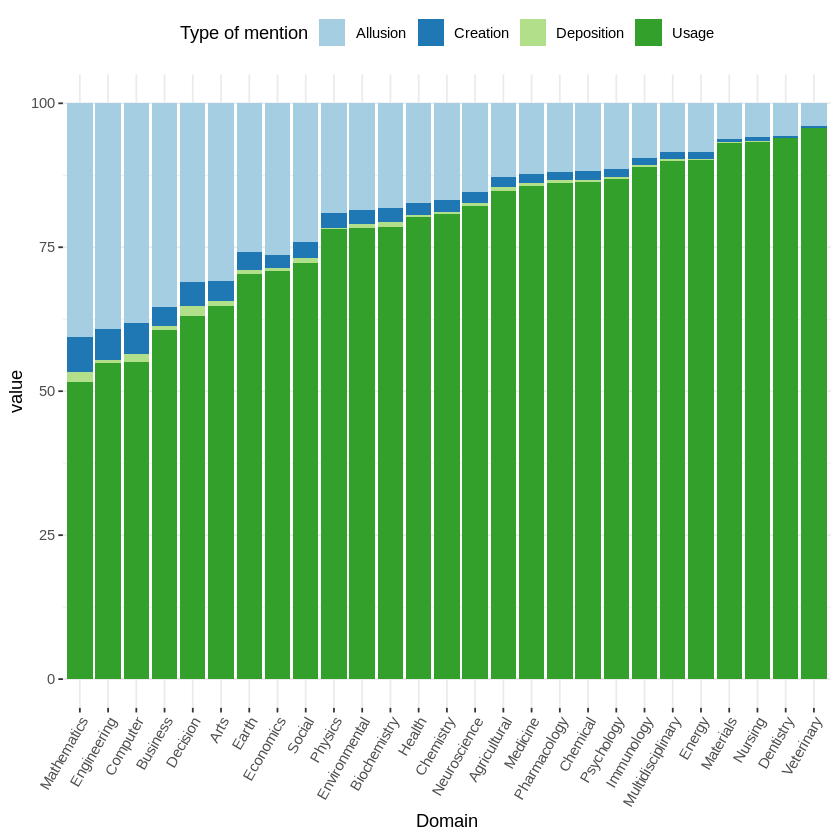

In [37]:
mentiontype_per_domain = run_and_cache(query="
SELECT
    ?concept
    ?mtype
    COUNT(DISTINCT ?article) as ?num_article
    COUNT(DISTINCT ?mention) as ?num_mention 
    COUNT(DISTINCT ?software) as ?num_software 
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
    ?article schema:mentions ?mention;
             dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 
    
    ?mention skgv:software ?software;
             skgv:mentionType ?mtype.
}
GROUP BY ?concept ?mtype
", cache.name="mentiontype_per_domain")
mentiontype_per_domain

mentiontype_per_domain %>%
    mutate_at("mtype", str_replace, "<http://data.gesis.org/softwarekg/vocab/MentionType_", "") %>%
    mutate_at("mtype",str_replace,">","") %>%
    group_by(concept) %>%
    mutate(num_mention=round(num_mention*100/sum(num_mention), digits=2)) %>%
    ungroup() %>%
    select(Domain=concept, MentionType=mtype, Frequency=num_mention) %>%
    pivot_wider(names_from="MentionType", values_from="Frequency") %>%
    select(Domain, Allusion, Usage, Creation, Deposition) %>%
    arrange(Usage) ->
domain_mentiontype

domain_mentiontype %>%
    mutate(Domain=stringr::str_split(Domain, ",") %>% map_chr(., 1)) %>%
    mutate(Domain=stringr::str_split(Domain, " ") %>% map_chr(., 1))%>%
    arrange(Usage) %>%
    mutate(Domain=factor(Domain, levels=Domain)) %>%
    pivot_longer(c('Usage', 'Allusion','Creation','Deposition')) %>%
    ggplot(., aes(Domain,value)) + 
    geom_bar(aes(fill=name), stat='identity') + 
    theme_sw() + 
    theme(axis.text.x=element_text(angle=60, hjust=1)) + 
    scale_fill_brewer("Type of mention", type='qual',palette=3)

Software Type per domain

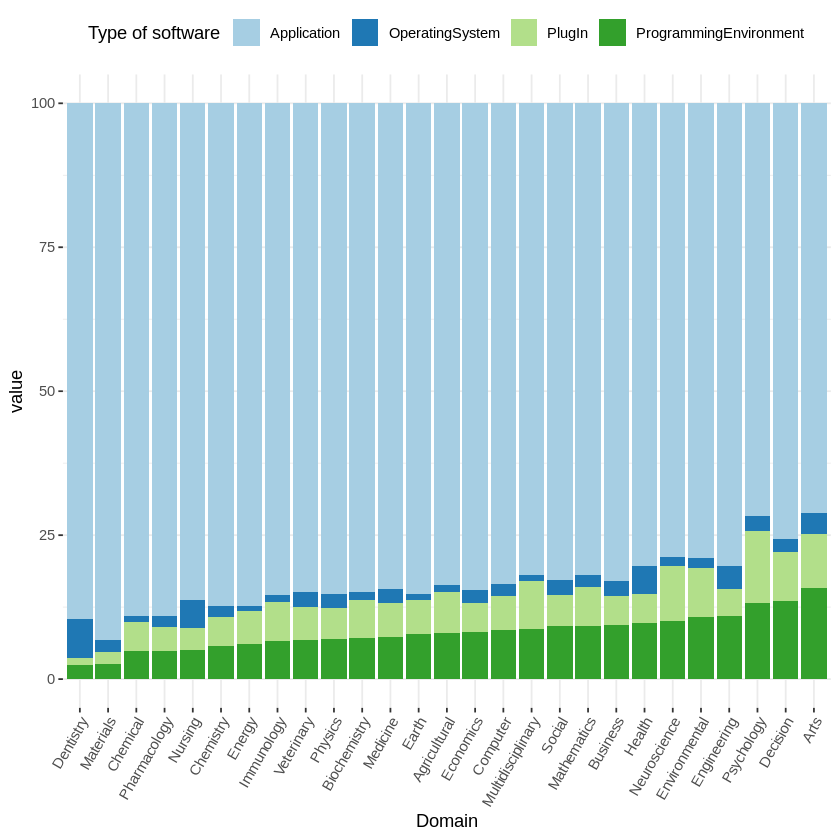

In [38]:
softwaretype_per_domain = run_and_cache(query="
SELECT
    ?concept
    ?stype
    COUNT(DISTINCT ?article) as ?num_article
    COUNT(DISTINCT ?mention) as ?num_mention 
    COUNT(DISTINCT ?software) as ?num_software 
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
    ?article schema:mentions ?mention;
             dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept. 
    
    ?mention skgv:software ?software;
             skgv:softwareType ?stype.
}
GROUP BY ?concept ?stype
", cache.name="softwaretype_per_domain")
#softwaretype_per_domain

softwaretype_per_domain %>%
    mutate_at("stype", str_replace, "<http://data.gesis.org/softwarekg/vocab/", "") %>%
    mutate_at("stype",str_replace,">","") %>%
    group_by(concept) %>%
    mutate(num_mention=round(num_mention*100/sum(num_mention), digits=2)) %>%
    ungroup() %>%
    select(Domain=concept, SoftwareType=stype, Frequency=num_mention) %>%
    pivot_wider(names_from="SoftwareType", values_from="Frequency") %>%
    select(Domain, ProgrammingEnvironment, OperatingSystem, Application, PlugIn) %>%
    arrange(Application) ->
domain_softwaretype
#domain_softwaretype

domain_softwaretype %>%
    mutate(Domain=stringr::str_split(Domain, ",") %>% map_chr(., 1)) %>%
    mutate(Domain=stringr::str_split(Domain, " ") %>% map_chr(., 1))%>%
    arrange(ProgrammingEnvironment) %>%
    mutate(Domain=factor(Domain, levels=Domain)) %>%
    pivot_longer(c('ProgrammingEnvironment', 'OperatingSystem','Application','PlugIn')) %>%
    ggplot(., aes(Domain,value)) + 
    geom_bar(aes(fill=name), stat='identity') + 
    theme_sw() + 
    theme(axis.text.x=element_text(angle=60, hjust=1)) + 
    scale_fill_brewer("Type of software", type='qual',palette=3)

In [39]:
softwaretype_per_year = run_and_cache(query="
SELECT
    year(?date) as ?year
    ?stype
    COUNT(DISTINCT ?article) as ?num_article
    COUNT(DISTINCT ?mention) as ?num_mention 
    COUNT(DISTINCT ?software) as ?num_software 
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
    ?article schema:mentions ?mention;
             schema:datePublished ?date. 
    
    ?mention skgv:software ?software;
             skgv:softwareType ?stype.

    FILTER (year(?date) >= 1990)
}
GROUP BY year(?date) ?stype
", cache.name="softwaretype_per_year")
#softwaretype_per_year

softwaretype_per_year %>%
    mutate_at("stype", str_replace, "<http://data.gesis.org/softwarekg/vocab/", "") %>%
    mutate_at("stype",str_replace,">","") %>%
    group_by(year) %>%
    mutate(num_mention=round(num_mention*100/sum(num_mention), digits=2)) %>%
    ungroup() %>%
    select(Year=year, SoftwareType=stype, Frequency=num_mention) %>%
    pivot_wider(names_from="SoftwareType", values_from="Frequency") %>%
    select(Year, ProgrammingEnvironment, OperatingSystem, Application, PlugIn) %>%
    arrange(Application) ->
year_softwaretype
#year_softwaretype

Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”
Warning message:
“Removed 1 row(s) containing missing values (geom_path).”
Warning message:
“Removed 6 rows containing missing values (geom_point).”


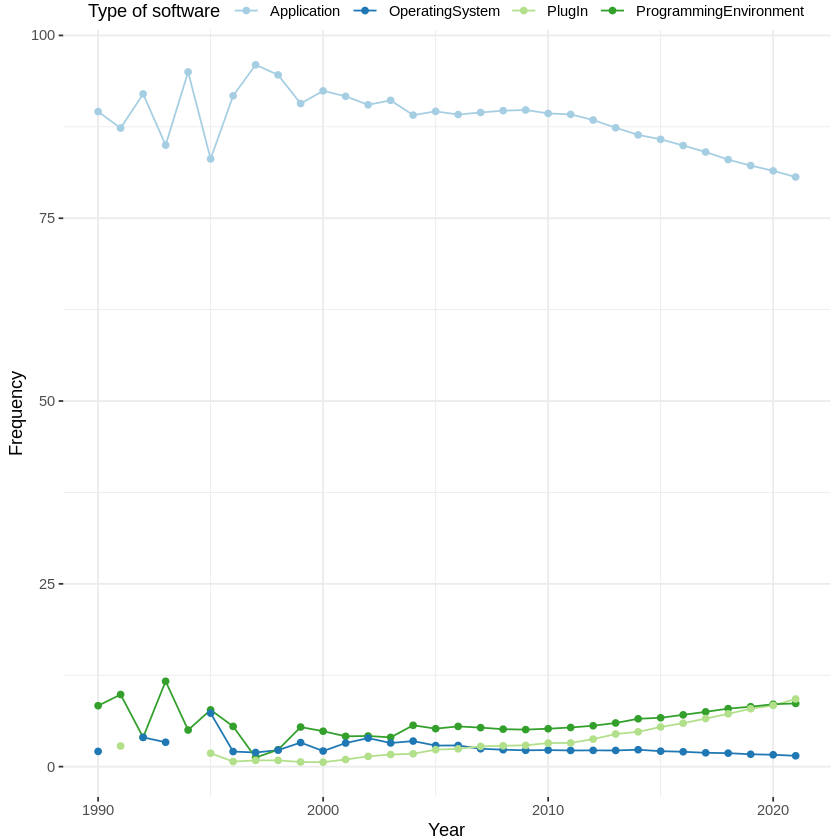

In [40]:
year_softwaretype %>%
    arrange(Year) %>%
    pivot_longer(c('ProgrammingEnvironment', 'OperatingSystem','Application','PlugIn')) %>%
    ggplot(., aes(Year,value)) + 
    geom_path(aes(color=name)) + 
    geom_point(aes(color=name)) + 
    theme(axis.text.x=element_text(angle=60, hjust=1)) + 
    scale_color_brewer("Type of software", type='qual',palette=3) + 
    ylab("Frequency") + 
    theme_sw() +
    theme( legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm")) ->
p_software_type_year

ggsave('software_type_per_year.png', p_software_type_year, width=8.5, height=3.7)
p_software_type_year

## Top Creation and Deposition Journals

In [41]:
top_software_journal = run_and_cache(query="
SELECT
    ?journal
    ?journal_name
    ?concept
    ?type
    COUNT(DISTINCT ?article) as ?num_article
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?journal a bibo:Journal;
             dct:subject/skos:hasTopConcept/schema:name ?concept; 
             schema:name ?journal_name.

    ?article dct:isPartOf ?journal;
             schema:mentions ?mention.

    ?mention skgv:software ?software;
             skgv:mentionType ?type.  
    FILTER(?type IN (skgv:MentionType_Creation, skgv:MentionType_Deposition))
}
GROUP BY ?journal ?journal_name ?concept ?type
ORDER BY DESC(?num_article)"
, cache.name="top_journals")

articles_in_journals = run_and_cache(query="
SELECT
    ?journal
    COUNT(DISTINCT ?article) as ?num_article
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE{
    ?journal a bibo:Journal.
    ?article dct:isPartOf ?journal.
}
GROUP BY ?journal", cache.name="articles_in_journals")

In [42]:
articles_in_journals %>%
filter(!journal %in% top_software_journal$journal) %>%
select(journal) %>%
distinct() %>%
nrow()

articles_in_journals %>%
filter(journal %in% top_software_journal$journal) %>%
select(journal) %>%
distinct() %>%
nrow()

[1] 11716

[1] 3622

In [43]:
top_software_journal %>%
    inner_join(articles_in_journals, by="journal") %>%
    rename(with_software=num_article.x, all=num_article.y) %>%
    mutate(r=with_software*100/all) %>%
    filter(all > 10) %>%
    arrange(desc(r)) %>%
head(n=20)

journal,journal_name,concept,type,with_software,all,r
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
<http://data.gesis.org/softwarekg/PMC/journal/5975>,Proceedings of the VLDB Endowment,Computer Science,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,10,11,90.90909
<http://data.gesis.org/softwarekg/PMC/journal/4384>,Source Code for Biology and Medicine,Medicine,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,146,173,84.39306
<http://data.gesis.org/softwarekg/PMC/journal/4384>,Source Code for Biology and Medicine,Decision Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,146,173,84.39306
<http://data.gesis.org/softwarekg/PMC/journal/4384>,Source Code for Biology and Medicine,Computer Science,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,146,173,84.39306
<http://data.gesis.org/softwarekg/PMC/journal/1075>,Database : the journal of biological databases and curation,Agricultural and Biological Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,902,1212,74.42244
<http://data.gesis.org/softwarekg/PMC/journal/1075>,Database : the journal of biological databases and curation,"Biochemistry, Genetics and Molecular Biology",<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,902,1212,74.42244
<http://data.gesis.org/softwarekg/PMC/journal/1075>,Database : the journal of biological databases and curation,Computer Science,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,902,1212,74.42244
<http://data.gesis.org/softwarekg/PMC/journal/5143>,Journal of Open Research Software,Social Sciences,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,8,11,72.72727
<http://data.gesis.org/softwarekg/PMC/journal/5143>,Journal of Open Research Software,Computer Science,<http://data.gesis.org/softwarekg/vocab/MentionType_Creation>,8,11,72.72727


# URLs

In [44]:
software_URLS = run_and_cache(query="
SELECT
    ?mention
    ?software
    ?URL_string
    ?type
FROM
    <http://data.gesis.org/softwarekg2>
WHERE
{
    [] schema:mentions ?mention .
    ?mention skgv:referredToByURL/nif:isString ?URL_string;
             skgv:software ?software;
             skgv:mentionType ?type.
}",cache.name="software_deposition_URLS")
head(software_URLS)

mention,software,URL_string,type
<chr>,<chr>,<chr>,<chr>
<http://data.gesis.org/softwarekg/PMC/article/PMC1998882/mentions/T11>,<http://data.gesis.org/softwarekg/PMC/software/1492080>,http : / / www . genome . lbl . gov / vista / index . shtml,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>
<http://data.gesis.org/softwarekg/PMC/article/PMC2171871/mentions/T3>,<http://data.gesis.org/softwarekg/PMC/software/1513169>,http : / / arrayconsortium . tgen . org,<http://data.gesis.org/softwarekg/vocab/MentionType_Deposition>
<http://data.gesis.org/softwarekg/PMC/article/PMC2267010/mentions/T3>,<http://data.gesis.org/softwarekg/PMC/software/846393>,http : / / www . mrc - lmb . cam . ac . uk / genomes / dolop /,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>
<http://data.gesis.org/softwarekg/PMC/article/PMC2527516/mentions/T12>,<http://data.gesis.org/softwarekg/PMC/software/1527007>,http : / / devolab . cse . msu . edu / software / avida,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>
<http://data.gesis.org/softwarekg/PMC/article/PMC2829050/mentions/T24>,<http://data.gesis.org/softwarekg/PMC/software/1474942>,http : / / www . Rproject . org,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>
<http://data.gesis.org/softwarekg/PMC/article/PMC2829050/mentions/T31>,<http://data.gesis.org/softwarekg/PMC/software/1481863>,http : / / llama . med . harvard . edu / cgi / func1 / funcassociate _ advanced,<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>


In [45]:
software_URLS %>%
    mutate(URL = gsub('\\s+', '',URL_string)) %>%
    mutate(URL = tolower(URL)) %>%
    mutate(URL = gsub('https?(:)?(//)?', '',URL)) %>%
    mutate(URL = gsub('(www\\.)?', '',URL)) %>%
    filter(URL != '') %>%
    mutate(URL = stringr::str_split(URL, "/") %>% map_chr(., 1)) %>%
    filter(grepl('.+\\..+', URL)) %>% 
    group_by(type, URL) %>%
    summarize(n=n()) %>%
    mutate(freq = n/sum(n)) %>%
    arrange(type, desc(n)) %>%
    mutate(position=row_number()) %>%
    ungroup() %>%
    filter(position <= 10) %>%
    filter(type =='<http://data.gesis.org/softwarekg/vocab/MentionType_Usage>' | type =='<http://data.gesis.org/softwarekg/vocab/MentionType_Deposition>') ->
    df_URL_sum 

df_URL_sum %>%
    mutate(freq=round(freq*100, digits=2)) %>%
    mutate(type=stringr::str_split(type, "_") %>% map_chr(., 2)) %>%
    mutate(type=stringr::str_split(type, ">") %>% map_chr(., 1)) %>%
    pivot_wider(names_from=type, values_from=c(URL, n, freq)) %>%
    select(URL_Deposition, n_Deposition, freq_Deposition, URL_Usage, n_Usage, freq_Usage) 

`summarise()` has grouped output by 'type'. You can override using the `.groups` argument.



URL_Deposition,n_Deposition,freq_Deposition,URL_Usage,n_Usage,freq_Usage
<chr>,<int>,<dbl>,<chr>,<int>,<dbl>
github.com,8602,13.93,github.com,18918,3.90
journals.plos.org,5926,9.60,ncbi.nlm.nih.gov,16830,3.47
sourceforge.net,918,1.49,r-project.org,13176,2.71
cran.r-project.org,673,1.09,pacev2.apexcovantage.com,10504,2.16
bioconductor.org,651,1.05,ebi.ac.uk,9850,2.03
ebi.ac.uk,478,0.77,blast.ncbi.nlm.nih.gov,8797,1.81
ncbi.nlm.nih.gov,454,0.74,cbs.dtu.dk,6539,1.35
bitbucket.org,423,0.69,fil.ion.ucl.ac.uk,6439,1.33
code.google.com,353,0.57,cran.r-project.org,6015,1.24


In [46]:
python_names = run_and_cache(query="
SELECT
    COUNT(DISTINCT ?smention) as ?num_mention
    GROUP_CONCAT(DISTINCT ?smention; SEPARATOR=\";\") as ?mentions
    ?software
WHERE{
    ?mention skgv:software ?software.
    ?mention nif:isString ?smention.
    FILTER (?software in (
                    <http://data.gesis.org/softwarekg/PMC/software/1475396>,
                    <http://data.gesis.org/softwarekg/PMC/software/1480565>,
                    <http://data.gesis.org/softwarekg/PMC/software/1478802>,
                    <http://data.gesis.org/softwarekg/PMC/software/1599843>))
}")
python_names

num_mention,mentions,software
<dbl>,<chr>,<chr>
1,PYthon,<http://data.gesis.org/softwarekg/PMC/software/1599843>
4,IPython;Ipython;Python;ipython,<http://data.gesis.org/softwarekg/PMC/software/1480565>
1,python,<http://data.gesis.org/softwarekg/PMC/software/1475396>
1,PYTHON,<http://data.gesis.org/softwarekg/PMC/software/1478802>


In [47]:
run_and_cache(query="
SELECT
COUNT(DISTINCT ?mention) as ?num
?smention
WHERE{
?mention skgv:software ?software.
?mention nif:isString ?smention.
FILTER (?software in (<http://data.gesis.org/softwarekg/PMC/software/1474910>))
} group by ?smention
order by desc(?num)")

num,smention
<dbl>,<chr>
131109,Excel
11911,excel
5012,Office Excel
1740,EXCEL
1162,Firefox
185,F
90,Flow
52,MICROSOFT EXCEL
36,MSExcel


In [48]:
run_and_cache(query="SELECT
COUNT(DISTINCT ?mention) as ?num
?smention
WHERE{
?mention skgv:software ?software.
?mention nif:isString ?smention.
FILTER (?software in (<http://data.gesis.org/softwarekg/PMC/software/1588559>))
} group by ?smention
order by desc(?num)")

num,smention
<dbl>,<chr>
76940,Stata
52362,STATA
11350,STAR
2100,FSTAT
1103,STAT
826,Stats
410,stata
342,TSA
279,Fstat


# Comparison of the most popular software for statistical analysis


In [49]:
stat_software_per_year = run_and_cache(query="
SELECT
    COUNT(DISTINCT ?article) as ?num_article
    ?software
    year(?date) as ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle;
            schema:mentions ?mention;
            schema:datePublished ?date.
    ?mention skgv:software ?software.
    FILTER (?software in (  <http://data.gesis.org/softwarekg/PMC/software/1474942>, #R 
                            <http://data.gesis.org/softwarekg/PMC/software/1482531>, #SPSS
                            <http://data.gesis.org/softwarekg/PMC/software/1474895>, #Prism
                            <http://data.gesis.org/softwarekg/PMC/software/1513869>, #ImageJ
                            <http://data.gesis.org/softwarekg/PMC/software/1588559>, #Stata
                            <http://data.gesis.org/softwarekg/PMC/software/1474910>, #Excel
                            <http://data.gesis.org/softwarekg/PMC/software/1493396>, #SAS
                            <http://data.gesis.org/softwarekg/PMC/software/1475396>, #python
                            <http://data.gesis.org/softwarekg/PMC/software/1480565> #Python
                        ))
    FILTER (year(?date) >= 1990)
} group by year(?date) ?software
order by ?year", cache.name="stat_software")

articles_with_software = run_and_cache(query="
SELECT
    COUNT(DISTINCT ?article) as ?num_article
    year(?date) as ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle;
            schema:mentions ?mention;
            schema:datePublished ?date.
    ?mention skgv:software [].
    FILTER (year(?date) >= 1990)
} group by year(?date)
order by ?year", cache.name="articles_per_year")

stat_software_social_sciences = run_and_cache(query="
SELECT
    COUNT(DISTINCT ?article) as ?num_article
    ?software
    year(?date) as ?year
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article a schema:ScholarlyArticle;
            schema:mentions ?mention;
            schema:datePublished ?date;
            dct:isPartOf/schema:name ?journal.
    ?mention skgv:software ?software.
    FILTER (?software in (  <http://data.gesis.org/softwarekg/PMC/software/1474942>, #R 
                            <http://data.gesis.org/softwarekg/PMC/software/1482531>, #SPSS
                            <http://data.gesis.org/softwarekg/PMC/software/1474895>, #Prism
                            <http://data.gesis.org/softwarekg/PMC/software/1513869>, #ImageJ
                            <http://data.gesis.org/softwarekg/PMC/software/1588559>, #Stata
                            <http://data.gesis.org/softwarekg/PMC/software/1474910>, #Excel
                            <http://data.gesis.org/softwarekg/PMC/software/1493396>, #SAS
                            <http://data.gesis.org/softwarekg/PMC/software/1475396>, #python
                            <http://data.gesis.org/softwarekg/PMC/software/1480565> #Python
                        ))
    FILTER (year(?date) >= 1990)
FILTER(?journal = \"PLoS ONE\")
} group by year(?date) ?software
order by ?year", cache.name="stat_software_social_sciences")

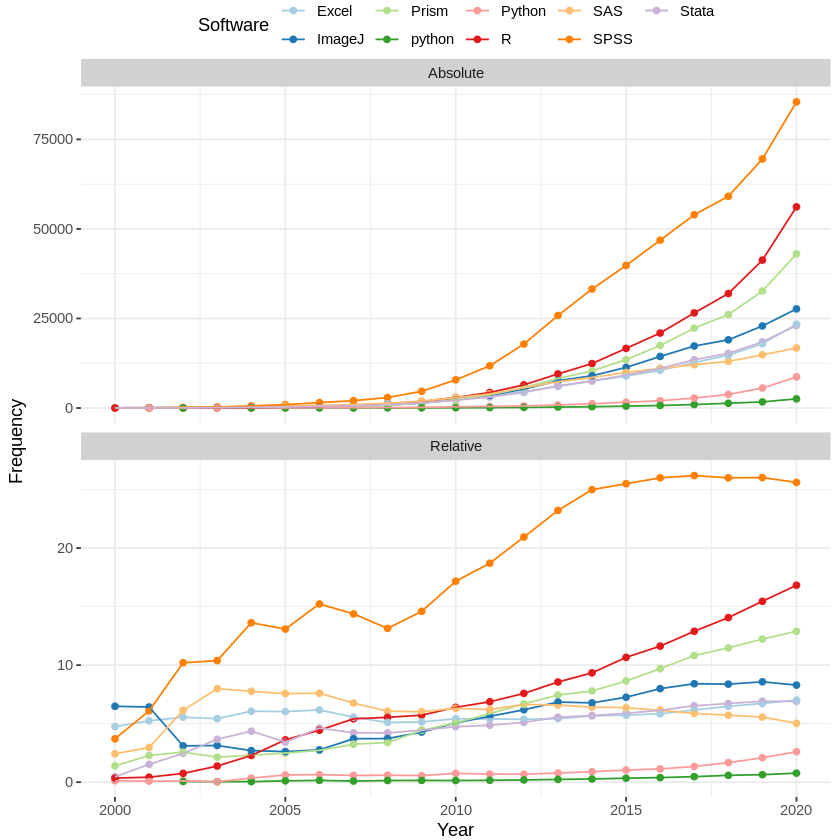

In [50]:
stat_software_per_year %>%
    inner_join(articles_with_software, by="year") %>%
    inner_join(software_names, by=c("software"="sw")) %>%
    filter(year>=2000) %>%
    filter(year<=2020) %>%
    mutate(Absolute=num_article.x, Relative=num_article.x*100/num_article.y) %>%
    dplyr::select(software=name, Absolute, Relative, year) %>%
    pivot_longer(c("Absolute", "Relative")) %>%
    ggplot(., aes(year, value)) +
        geom_point(aes(color=software)) + 
        geom_line(aes(color=software)) + 
        facet_wrap(~name, nrow=2, scales = 'free_y') + 
        scale_color_brewer("Software", type='qual', palette=3) +
        ylab("Frequency") + xlab("Year") +
        theme_sw() +
        theme( legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm")) -> 
p_stat_software

ggsave(p_stat_software, filename = "stat_software_per_year.png", height=6, width=10)
p_stat_software

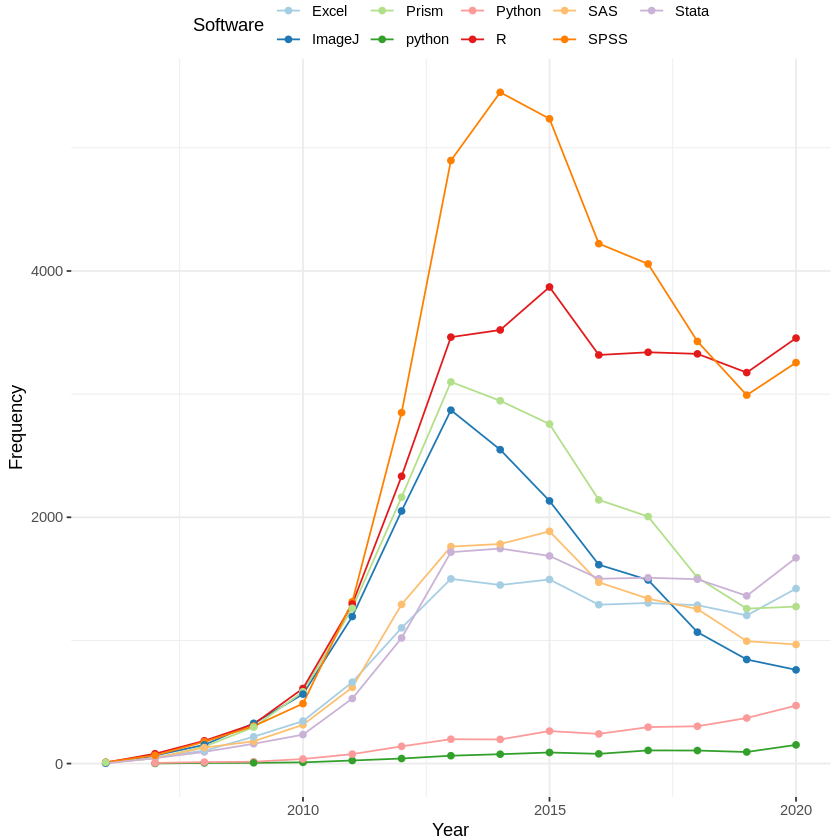

In [51]:
stat_software_social_sciences %>%
    inner_join(software_names, by=c("software"="sw")) %>%
    filter(year<=2020) %>%
    dplyr::select(name, year, num_article) %>%
    ggplot(., aes(year, num_article)) + 
        geom_line(aes(color=name)) + 
        geom_point(aes(color=name)) +
     scale_color_brewer("Software", type='qual', palette=3) +
        ylab("Frequency") + xlab("Year") + 
theme_sw() + 
theme( legend.justification="top",
                legend.margin=margin(0,0,0,0),
                legend.box.margin=margin(-8,-8,-8,-8),
                 plot.margin = unit(c(0.2,0.2,0,0.2), "cm"))

## Analysis of journal citation count in dependence of how long a journal exists

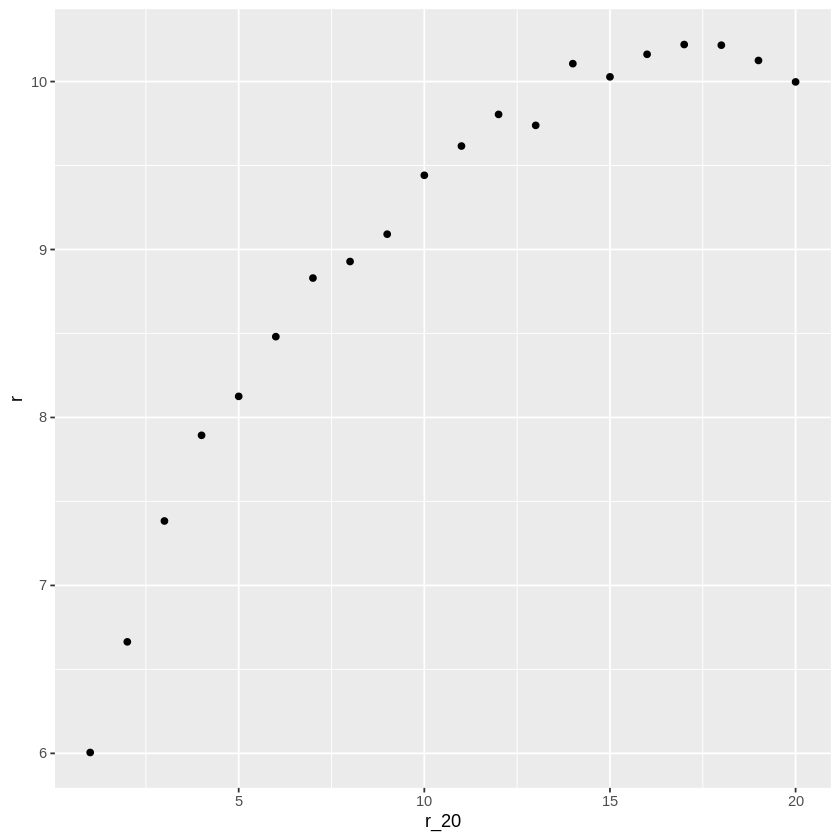

In [52]:
# Are newer journals ranked lower?

rank_per_year = run_and_cache(query="      
SELECT 
    ?rank
    COUNT(DISTINCT ?journal) as?num_journal
    xsd:float(COUNT(DISTINCT ?ji2))/xsd:float(COUNT(DISTINCT ?journal)) as ?avg_years_ranked
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?journal skgv:hasJournalInformation ?ji.
    ?ji skgv:rank ?rank;
        dct:date ?date.

    ?journal skgv:hasJournalInformation ?ji2.
    ?ji2 dct:date ?date2.
    FILTER(?date2 < ?date)
}
GROUP BY ?rank
ORDER BY ?rank", cache.name="rank_per_year")

rank_per_year %>%
    uncount(num_journal) %>%
    mutate(r_20 = ntile(rank,20)) %>%
    group_by(r_20) %>%
    summarise(r=mean(avg_years_ranked)) %>%
    ggplot(., aes(r_20,r)) +
       geom_point()

In [53]:
creations_with_software_type = run_and_cache(query="
SELECT
    ?concept
    ?mtype
    ?stype
FROM 
    <http://data.gesis.org/softwarekg2> 
WHERE
{
    ?article dct:isPartOf/dct:subject/skos:hasTopConcept/schema:name ?concept;
             schema:mentions ?mention.

    ?mention skgv:software ?software;
             skgv:mentionType ?mtype;
             skgv:softwareType ?stype.

    FILTER(?mtype IN (skgv:MentionType_Creation, skgv:MentionType_Deposition))
}"
, cache.name="creations_with_software_type")

In [54]:
creations_with_software_type %>%
    #filter(mtype=='<http://data.gesis.org/softwarekg/vocab/MentionType_Deposition>') %>%
    group_by(concept, stype) %>%
    summarize(n=n()) %>%
    ungroup() %>%
    group_by(concept) %>%
    mutate(n=n/sum(n)) %>%
    ungroup() %>%
    pivot_wider(names_from='stype', values_from='n') %>%
    replace(is.na(.), 0) %>%
    arrange(`<http://data.gesis.org/softwarekg/vocab/PlugIn>`)

`summarise()` has grouped output by 'concept'. You can override using the `.groups` argument.



concept,<http://data.gesis.org/softwarekg/vocab/Application>,<http://data.gesis.org/softwarekg/vocab/OperatingSystem>,<http://data.gesis.org/softwarekg/vocab/PlugIn>,<http://data.gesis.org/softwarekg/vocab/ProgrammingEnvironment>
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Dentistry,0.9878788,0.000000e+00,0.01212121,0.0000000000
Nursing,0.9633588,0.000000e+00,0.03664122,0.0000000000
"Business, Management and Accounting",0.9530075,0.000000e+00,0.04699248,0.0000000000
Veterinary,0.9472222,0.000000e+00,0.05277778,0.0000000000
Earth and Planetary Sciences,0.9424460,0.000000e+00,0.05755396,0.0000000000
Materials Science,0.9415488,0.000000e+00,0.05807893,0.0003723008
Social Sciences,0.9404067,1.576541e-04,0.05864733,0.0007882705
Energy,0.9318885,0.000000e+00,0.06811146,0.0000000000
Engineering,0.9296800,3.507234e-04,0.06957475,0.0003945638


In [55]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /opt/conda/lib/libopenblasp-r0.3.17.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] grid      stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] magrittr_2.0.1  gridExtra_2.3   xtable_1.8-4    tictoc_1.0.1   
 [5] digest_0.6.28   SPARQL_1.16     RCurl_1.98-1.5  XML_3.99-0.8   
 [9] forcats_0.5.1   stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4    
[13] readr_2.0.2     tidyr_1.1.4     tibble_3.1.5    ggplot2_3.3.5  
[17] tidyverse_1.3.1

loaded via a name